# Описание проекта

Подготовьте прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. В вашем распоряжении данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Вам нужно:

1. Подготовить данные;
2. Провести исследовательский анализ данных;
3. Построить и обучить модель.

Чтобы выполнить проект, обращайтесь к библиотекам *pandas*, *matplotlib* и *sklearn.* Вам поможет их документация.

## Содержание:
* [Шаг 1. Подготовка данных](#first-step)
    * [Промежуточный вывод](#first1-step)
* [Шаг 1. Вывод](#first-conclusion)
* [Шаг 2. Анализ данных](#second-step)
    * [2.1 Промежуточный вывод](#second21-conclusion)
    * [2.2 Промежуточный вывод](#second22-conclusion)
    * [2.3 Промежуточный вывод](#second23-conclusion)
* [Шаг 2. Вывод](#second-conclusion)
* [Шаг 3. Модель](#third-step)
* [Шаг 3. Вывод](#third-conclusion)

# 1. Подготовка данных    <a class="anchor" id="first-step"></a>

1. Подготовьте данные  
1.1. Откройте файлы и изучите их.  
1.2. Проверьте, что эффективность обогащения рассчитана правильно. Вычислите её на обучающей выборке для признака  rougher.output.recovery. Найдите MAE между вашими расчётами и значением признака. Опишите выводы.  
1.3. Проанализируйте признаки, недоступные в тестовой выборке. Что это за параметры? К какому типу относятся?  
1.4. Проведите предобработку данных.  

Данные находятся в трёх файлах:  
gold_recovery_train.csv — обучающая выборка;  
gold_recovery_test.csv — тестовая выборка;  
gold_recovery_full.csv — исходные данные.  

Данные индексируются датой и временем получения информации (признак date). Соседние по времени параметры часто похожи.

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
import numpy as np 
from scipy import stats as st
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.dummy import DummyRegressor
from sklearn.metrics import make_scorer
from sklearn.model_selection import RandomizedSearchCV
from time import time

In [8]:
df_full = pd.read_csv('datasets\gold_recovery_full.csv')
df_test = pd.read_csv('datasets\gold_recovery_test.csv')
df_train = pd.read_csv('datasets\gold_recovery_train.csv')

c_df_full = df_full.shape[0] #количество записей в исходном наборе до манипуляций
c_df_test = df_test.shape[0] #количество записей в тестовой выборке до манипуляций
c_df_train = df_train.shape[0] #количество записей в обучающей выборке до манипуляций

In [9]:
print('Количество записей в обучающей выборке', c_df_test)
print('количество записей ', df_full[df_full.index.isin(df_test.index)].shape[0])

Количество записей в обучающей выборке 5856
количество записей  5856


In [10]:
print('Количество записей в обучающей выборке', c_df_train)
print('количество записей ', df_full[df_full.index.isin(df_train.index)].shape[0])

Количество записей в обучающей выборке 16860
количество записей  16860


In [11]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_rows', None)

from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))

#Функция, которая к основной информации из метода info добавляет информацию о доли пропущенных значений
def file_info_null(df_tmp): 
    df1_tmp = pd.DataFrame(df_tmp.dtypes)
    df1_tmp = df1_tmp.reset_index()
    df1_tmp.columns = ['name','type']
    df1_tmp['NN_Count'] = 0 #столбце для количества не пустых значений в столбце DataFrame
    df1_tmp['isnull']  = 0    
    c1 = len(df_tmp.index)
    for i in range(0,len(df_tmp.columns)):
        df1_tmp.loc[i,'NN_Count'] =  df_tmp[df_tmp.columns[i]].count()
        df1_tmp.loc[i,'isnull'] = (c1 - df_tmp[df_tmp.columns[i]].count()) / c1
    
    cm = sns.light_palette("green", as_cmap=True)
    s = df1_tmp.sort_values(by = 'isnull', ascending = False).style.background_gradient(cmap=cm)
    print(df1_tmp.sort_values(by = 'isnull', ascending = False).to_string(formatters={'isnull':'{:.2%}'.format}))
    
    
def file_info(df):
    printmd('**Общая информация - метод info**')
    file_info_null(df)
    for col in df.columns:
        temp_str = '**Описание столбца ' + col + '**'
        printmd(temp_str)
        print(df[col].describe())
     
    printmd('**Есть ли дубликаты**')
    print(df.duplicated().sum())  

#Функция высчитывает различие в столбцах между полными исходными данныеми и выборками
def diff_columns(df):
    full_col = df_full.columns
    col1 = df.columns
    return pd.Series((list(set(full_col) - set(col1)))).sort_values()

Информация о файле с исходными данными

In [12]:
file_info(df_full)

**Общая информация - метод info**

                                                 name     type  NN_Count isnull
48                            rougher.output.recovery  float64     19597 13.73%
49                             rougher.output.tail_ag  float64     19979 12.05%
52                             rougher.output.tail_au  float64     19980 12.04%
51                            rougher.output.tail_sol  float64     19980 12.04%
43                 rougher.input.floatbank11_xanthate  float64     20459  9.94%
67                  secondary_cleaner.output.tail_sol  float64     20501  9.75%
5                               final.output.recovery  float64     20753  8.64%
33                    rougher.calculation.au_pb_ratio  float64     21089  7.16%
10                      primary_cleaner.input.sulfate  float64     21107  7.08%
11                   primary_cleaner.input.depressant  float64     21170  6.81%
40                  rougher.input.floatbank10_sulfate  float64     21415  5.73%
13                     primary_cleaner.i

**Описание столбца date**

count                   22716
unique                  22716
top       2016-10-11 19:59:59
freq                        1
Name: date, dtype: object


**Описание столбца final.output.concentrate_ag**

count    22627.000000
mean         4.781559
std          2.030128
min          0.000000
25%          4.018525
50%          4.953729
75%          5.862593
max         16.001945
Name: final.output.concentrate_ag, dtype: float64


**Описание столбца final.output.concentrate_pb**

count    22629.000000
mean         9.095308
std          3.230797
min          0.000000
25%          8.750171
50%          9.914519
75%         10.929839
max         17.031899
Name: final.output.concentrate_pb, dtype: float64


**Описание столбца final.output.concentrate_sol**

count    22331.000000
mean         8.640317
std          3.785035
min          0.000000
25%          7.116799
50%          8.908792
75%         10.705824
max         19.615720
Name: final.output.concentrate_sol, dtype: float64


**Описание столбца final.output.concentrate_au**

count    22630.000000
mean        40.001172
std         13.398062
min          0.000000
25%         42.383721
50%         44.653436
75%         46.111999
max         53.611374
Name: final.output.concentrate_au, dtype: float64


**Описание столбца final.output.recovery**

count    20753.000000
mean        67.447488
std         11.616034
min          0.000000
25%         63.282393
50%         68.322258
75%         72.950836
max        100.000000
Name: final.output.recovery, dtype: float64


**Описание столбца final.output.tail_ag**

count    22633.000000
mean         8.923690
std          3.517917
min          0.000000
25%          7.684016
50%          9.484369
75%         11.084557
max         19.552149
Name: final.output.tail_ag, dtype: float64


**Описание столбца final.output.tail_pb**

count    22516.000000
mean         2.488252
std          1.189407
min          0.000000
25%          1.805376
50%          2.653001
75%          3.287790
max          6.086532
Name: final.output.tail_pb, dtype: float64


**Описание столбца final.output.tail_sol**

count    22445.000000
mean         9.523632
std          4.079739
min          0.000000
25%          8.143576
50%         10.212998
75%         11.860824
max         22.861749
Name: final.output.tail_sol, dtype: float64


**Описание столбца final.output.tail_au**

count    22635.000000
mean         2.827459
std          1.262834
min          0.000000
25%          2.303108
50%          2.913794
75%          3.555077
max          9.789625
Name: final.output.tail_au, dtype: float64


**Описание столбца primary_cleaner.input.sulfate**

count    21107.000000
mean       140.277672
std         49.919004
min          0.000003
25%        110.177081
50%        141.330501
75%        174.049914
max        274.409626
Name: primary_cleaner.input.sulfate, dtype: float64


**Описание столбца primary_cleaner.input.depressant**

count    21170.000000
mean         8.587607
std          3.611361
min          0.000000
25%          6.018085
50%          8.018173
75%         11.003573
max         40.024582
Name: primary_cleaner.input.depressant, dtype: float64


**Описание столбца primary_cleaner.input.feed_size**

count    22716.000000
mean         7.288872
std          0.617357
min          1.080000
25%          6.920000
50%          7.280000
75%          7.680000
max         15.500000
Name: primary_cleaner.input.feed_size, dtype: float64


**Описание столбца primary_cleaner.input.xanthate**

count    21565.000000
mean         0.969830
std          0.548083
min          0.000003
25%          0.626346
50%          0.905286
75%          1.200734
max          6.027907
Name: primary_cleaner.input.xanthate, dtype: float64


**Описание столбца primary_cleaner.output.concentrate_ag**

count    22618.000000
mean         7.691652
std          3.109306
min          0.000000
25%          6.771102
50%          8.265643
75%          9.697896
max         16.081632
Name: primary_cleaner.output.concentrate_ag, dtype: float64


**Описание столбца primary_cleaner.output.concentrate_pb**

count    22268.000000
mean         8.921110
std          3.706314
min          0.000000
25%          7.834690
50%          9.921116
75%         11.266100
max         17.081278
Name: primary_cleaner.output.concentrate_pb, dtype: float64


**Описание столбца primary_cleaner.output.concentrate_sol**

count    21918.000000
mean         9.573672
std          4.788433
min          0.000000
25%          7.009980
50%          9.851136
75%         13.180304
max         22.458114
Name: primary_cleaner.output.concentrate_sol, dtype: float64


**Описание столбца primary_cleaner.output.concentrate_au**

count    22618.000000
mean        29.212289
std         10.539303
min          0.000000
25%         29.374406
50%         32.359813
75%         34.770726
max         45.933934
Name: primary_cleaner.output.concentrate_au, dtype: float64


**Описание столбца primary_cleaner.output.tail_ag**

count    22614.000000
mean        14.876219
std          5.654342
min          0.000000
25%         13.464756
50%         15.600454
75%         17.931084
max         29.459575
Name: primary_cleaner.output.tail_ag, dtype: float64


**Описание столбца primary_cleaner.output.tail_pb**

count    22594.000000
mean         3.175822
std          1.652177
min          0.000000
25%          2.269103
50%          3.154022
75%          4.123574
max          9.634565
Name: primary_cleaner.output.tail_pb, dtype: float64


**Описание столбца primary_cleaner.output.tail_sol**

count    22365.000000
mean         7.208474
std          3.087892
min          0.000000
25%          5.961535
50%          7.873945
75%          9.348743
max         22.276364
Name: primary_cleaner.output.tail_sol, dtype: float64


**Описание столбца primary_cleaner.output.tail_au**

count    22617.000000
mean         3.670333
std          1.985206
min          0.000000
25%          2.741534
50%          3.513008
75%          4.559485
max         18.528821
Name: primary_cleaner.output.tail_au, dtype: float64


**Описание столбца primary_cleaner.state.floatbank8_a_air**

count    22660.000000
mean      1511.162809
std        363.801472
min          0.000000
25%       1500.593119
50%       1600.079008
75%       1696.691067
max       2212.432090
Name: primary_cleaner.state.floatbank8_a_air, dtype: float64


**Описание столбца primary_cleaner.state.floatbank8_a_level**

count    22667.000000
mean      -506.647591
std         73.798002
min       -800.037388
25%       -500.426010
50%       -499.963174
75%       -499.458089
max        -57.195404
Name: primary_cleaner.state.floatbank8_a_level, dtype: float64


**Описание столбца primary_cleaner.state.floatbank8_b_air**

count    22660.000000
mean      1514.351654
std        365.280954
min          0.000000
25%       1500.500790
50%       1600.032196
75%       1698.933079
max       2361.414084
Name: primary_cleaner.state.floatbank8_b_air, dtype: float64


**Описание столбца primary_cleaner.state.floatbank8_b_level**

count    22673.000000
mean      -508.478882
std         76.785239
min       -800.409770
25%       -500.558891
50%       -500.001770
75%       -499.414187
max       -142.527229
Name: primary_cleaner.state.floatbank8_b_level, dtype: float64


**Описание столбца primary_cleaner.state.floatbank8_c_air**

count    22662.000000
mean      1502.534056
std        376.634842
min          0.000000
25%       1499.146216
50%       1599.749504
75%       1699.151169
max       2042.072583
Name: primary_cleaner.state.floatbank8_c_air, dtype: float64


**Описание столбца primary_cleaner.state.floatbank8_c_level**

count    22673.000000
mean      -507.776133
std         75.003917
min       -800.362914
25%       -500.953774
50%       -499.982485
75%       -498.932758
max       -150.937035
Name: primary_cleaner.state.floatbank8_c_level, dtype: float64


**Описание столбца primary_cleaner.state.floatbank8_d_air**

count    22661.000000
mean      1473.186236
std        414.691424
min          0.000000
25%       1447.698210
50%       1598.993577
75%       1698.142189
max       2398.903635
Name: primary_cleaner.state.floatbank8_d_air, dtype: float64


**Описание столбца primary_cleaner.state.floatbank8_d_level**

count    22673.000000
mean      -504.124775
std         82.278973
min       -800.166222
25%       -500.616787
50%       -499.961283
75%       -499.135326
max        -20.654343
Name: primary_cleaner.state.floatbank8_d_level, dtype: float64


**Описание столбца rougher.calculation.sulfate_to_au_concentrate**

count    2.267200e+04
mean    -6.294614e+06
std      9.826921e+07
min     -2.248017e+09
25%      3.988478e+04
50%      4.405929e+04
75%      4.814479e+04
max      8.332404e+07
Name: rougher.calculation.sulfate_to_au_concentrate, dtype: float64


**Описание столбца rougher.calculation.floatbank10_sulfate_to_au_feed**

count    2.267200e+04
mean     3.559534e+03
std      6.116649e+04
min     -2.023459e+06
25%      2.506366e+03
50%      2.940838e+03
75%      3.613983e+03
max      6.211433e+06
Name: rougher.calculation.floatbank10_sulfate_to_au_feed, dtype: float64


**Описание столбца rougher.calculation.floatbank11_sulfate_to_au_feed**

count    2.267200e+04
mean     2.294828e+03
std      4.177895e+04
min     -4.014502e+06
25%      2.501745e+03
50%      2.897014e+03
75%      3.529913e+03
max      1.537564e+06
Name: rougher.calculation.floatbank11_sulfate_to_au_feed, dtype: float64


**Описание столбца rougher.calculation.au_pb_ratio**

count    21089.000000
mean         2.386287
std          0.839999
min         -0.010548
25%          2.021360
50%          2.286493
75%          2.711070
max         39.379272
Name: rougher.calculation.au_pb_ratio, dtype: float64


**Описание столбца rougher.input.feed_ag**

count    22618.000000
mean         8.065715
std          3.125250
min          0.000000
25%          6.944415
50%          8.302613
75%         10.135202
max         14.869652
Name: rougher.input.feed_ag, dtype: float64


**Описание столбца rougher.input.feed_pb**

count    22472.000000
mean         3.305676
std          1.446905
min          0.000000
25%          2.658814
50%          3.432054
75%          4.204960
max          7.142594
Name: rougher.input.feed_pb, dtype: float64


**Описание столбца rougher.input.feed_rate**

count    22163.000000
mean       441.873650
std        156.736078
min          0.000044
25%        398.222097
50%        488.968597
75%        546.587401
max        717.508837
Name: rougher.input.feed_rate, dtype: float64


**Описание столбца rougher.input.feed_size**

count    22277.000000
mean        57.959166
std         23.644823
min          0.046369
25%         46.687088
50%         53.405122
75%         64.096151
max        484.967466
Name: rougher.input.feed_size, dtype: float64


**Описание столбца rougher.input.feed_sol**

count    22357.000000
mean        33.276016
std         11.494135
min          0.000000
25%         32.524264
50%         36.559955
75%         39.675470
max         53.477742
Name: rougher.input.feed_sol, dtype: float64


**Описание столбца rougher.input.feed_au**

count    22617.000000
mean         7.565838
std          3.026954
min          0.000000
25%          6.485009
50%          7.884832
75%          9.668064
max         14.093363
Name: rougher.input.feed_au, dtype: float64


**Описание столбца rougher.input.floatbank10_sulfate**

count    21415.000000
mean        11.784263
std          4.093125
min          0.000002
25%          9.915698
50%         11.998801
75%         14.437582
max         36.118275
Name: rougher.input.floatbank10_sulfate, dtype: float64


**Описание столбца rougher.input.floatbank10_xanthate**

count    22247.000000
mean         5.573526
std          1.908123
min          0.000003
25%          5.046782
50%          5.999078
75%          6.700493
max         31.493331
Name: rougher.input.floatbank10_xanthate, dtype: float64


**Описание столбца rougher.input.floatbank11_sulfate**

count    22038.000000
mean        11.209718
std          4.685205
min          0.000014
25%          9.281388
50%         11.946466
75%         14.015696
max         37.980648
Name: rougher.input.floatbank11_sulfate, dtype: float64


**Описание столбца rougher.input.floatbank11_xanthate**

count    20459.000000
mean         5.962586
std          1.280682
min          0.000010
25%          5.353321
50%          6.034551
75%          6.799526
max         18.709478
Name: rougher.input.floatbank11_xanthate, dtype: float64


**Описание столбца rougher.output.concentrate_ag**

count    22618.000000
mean        10.874484
std          4.377924
min          0.000000
25%         10.126646
50%         11.785127
75%         13.615299
max         24.480271
Name: rougher.output.concentrate_ag, dtype: float64


**Описание столбца rougher.output.concentrate_pb**

count    22618.000000
mean         6.900646
std          2.806948
min          0.000000
25%          6.374692
50%          7.572855
75%          8.477358
max         18.394042
Name: rougher.output.concentrate_pb, dtype: float64


**Описание столбца rougher.output.concentrate_sol**

count    22526.000000
mean        26.095508
std         10.140120
min          0.000000
25%         25.815139
50%         29.382638
75%         32.002766
max         40.089993
Name: rougher.output.concentrate_sol, dtype: float64


**Описание столбца rougher.output.concentrate_au**

count    22618.000000
mean        17.879538
std          6.790112
min          0.000000
25%         17.928729
50%         20.003202
75%         21.564238
max         28.824507
Name: rougher.output.concentrate_au, dtype: float64


**Описание столбца rougher.output.recovery**

count    19597.000000
mean        83.078122
std         14.661880
min          0.000000
25%         80.941306
50%         86.144121
75%         89.987561
max        100.000000
Name: rougher.output.recovery, dtype: float64


**Описание столбца rougher.output.tail_ag**

count    19979.000000
mean         5.587861
std          1.114614
min          0.594562
25%          4.887758
50%          5.759630
75%          6.386301
max         12.719177
Name: rougher.output.tail_ag, dtype: float64


**Описание столбца rougher.output.tail_pb**

count    22618.000000
mean         0.593620
std          0.315295
min          0.000000
25%          0.427513
50%          0.590746
75%          0.763219
max          3.778064
Name: rougher.output.tail_pb, dtype: float64


**Описание столбца rougher.output.tail_sol**

count    19980.000000
mean        18.040138
std          3.470514
min         10.014648
25%         15.788283
50%         18.082595
75%         20.084427
max         66.117188
Name: rougher.output.tail_sol, dtype: float64


**Описание столбца rougher.output.tail_au**

count    19980.000000
mean         1.821193
std          0.695663
min          0.020676
25%          1.403951
50%          1.808567
75%          2.215317
max          9.688980
Name: rougher.output.tail_au, dtype: float64


**Описание столбца rougher.state.floatbank10_a_air**

count    22646.000000
mean      1061.497265
std        277.718805
min         -0.345168
25%        999.482192
50%       1000.874850
75%       1210.446131
max       1521.980372
Name: rougher.state.floatbank10_a_air, dtype: float64


**Описание столбца rougher.state.floatbank10_a_level**

count    22647.000000
mean      -389.490702
std        109.946946
min       -658.223080
25%       -499.930417
50%       -300.401147
75%       -299.992579
max        -19.383282
Name: rougher.state.floatbank10_a_level, dtype: float64


**Описание столбца rougher.state.floatbank10_b_air**

count    22646.000000
mean      1257.007638
std        319.983248
min         -0.821921
25%       1197.548268
50%       1299.976586
75%       1407.132038
max       1809.194008
Name: rougher.state.floatbank10_b_air, dtype: float64


**Описание столбца rougher.state.floatbank10_b_level**

count    22647.000000
mean      -477.174011
std         66.645938
min       -650.437575
25%       -500.297595
50%       -499.847233
75%       -403.034804
max          9.457822
Name: rougher.state.floatbank10_b_level, dtype: float64


**Описание столбца rougher.state.floatbank10_c_air**

count    22646.000000
mean      1235.736890
std        331.886940
min         -0.378521
25%       1100.701647
50%       1298.358825
75%       1437.004925
max       2499.129174
Name: rougher.state.floatbank10_c_air, dtype: float64


**Описание столбца rougher.state.floatbank10_c_level**

count    22654.000000
mean      -476.320380
std         63.957539
min       -650.151190
25%       -500.323902
50%       -499.786527
75%       -403.386144
max        -10.242658
Name: rougher.state.floatbank10_c_level, dtype: float64


**Описание столбца rougher.state.floatbank10_d_air**

count    22641.000000
mean      1152.689097
std        317.187293
min         -1.197435
25%       1040.497698
50%       1200.061465
75%       1342.550632
max       2077.222699
Name: rougher.state.floatbank10_d_air, dtype: float64


**Описание столбца rougher.state.floatbank10_d_level**

count    22649.000000
mean      -477.720243
std         61.942486
min       -649.300693
25%       -500.590442
50%       -499.674320
75%       -443.310570
max         21.365035
Name: rougher.state.floatbank10_d_level, dtype: float64


**Описание столбца rougher.state.floatbank10_e_air**

count    22096.000000
mean      1029.790755
std        278.544787
min         -2.163619
25%        950.272126
50%       1049.208185
75%       1198.762174
max       2330.310425
Name: rougher.state.floatbank10_e_air, dtype: float64


**Описание столбца rougher.state.floatbank10_e_level**

count    22649.000000
mean      -475.804766
std         68.327502
min       -650.196204
25%       -500.357323
50%       -499.749602
75%       -403.199939
max         -2.406020
Name: rougher.state.floatbank10_e_level, dtype: float64


**Описание столбца rougher.state.floatbank10_f_air**

count    22641.000000
mean       977.870710
std        262.604257
min         -2.636171
25%        900.173576
50%        999.693303
75%       1099.189914
max       1950.493751
Name: rougher.state.floatbank10_f_air, dtype: float64


**Описание столбца rougher.state.floatbank10_f_level**

count    22642.000000
mean      -476.448631
std         69.678409
min       -650.072915
25%       -500.749731
50%       -499.631519
75%       -403.810536
max        -21.745268
Name: rougher.state.floatbank10_f_level, dtype: float64


**Описание столбца secondary_cleaner.output.tail_ag**

count    22616.000000
mean        13.375349
std          5.768719
min          0.000000
25%         11.802936
50%         15.222165
75%         17.231611
max         23.264738
Name: secondary_cleaner.output.tail_ag, dtype: float64


**Описание столбца secondary_cleaner.output.tail_pb**

count    22600.000000
mean         5.304107
std          3.092536
min          0.000000
25%          3.451435
50%          5.074145
75%          7.585281
max         17.042505
Name: secondary_cleaner.output.tail_pb, dtype: float64


**Описание столбца secondary_cleaner.output.tail_sol**

count    20501.000000
mean         6.465460
std          4.277993
min          0.000000
25%          2.658971
50%          6.966645
75%         10.152612
max         33.058594
Name: secondary_cleaner.output.tail_sol, dtype: float64


**Описание столбца secondary_cleaner.output.tail_au**

count    22618.000000
mean         4.041218
std          2.605738
min          0.000000
25%          2.877554
50%          3.956171
75%          5.006944
max         26.811643
Name: secondary_cleaner.output.tail_au, dtype: float64


**Описание столбца secondary_cleaner.state.floatbank2_a_air**

count    22333.000000
mean        27.440808
std          7.763001
min          0.000000
25%         25.011462
50%         28.927709
75%         32.892271
max         60.000000
Name: secondary_cleaner.state.floatbank2_a_air, dtype: float64


**Описание столбца secondary_cleaner.state.floatbank2_a_level**

count    22591.000000
mean      -516.727003
std         83.411562
min       -799.841677
25%       -500.303776
50%       -499.996457
75%       -499.686110
max       -127.875565
Name: secondary_cleaner.state.floatbank2_a_level, dtype: float64


**Описание столбца secondary_cleaner.state.floatbank2_b_air**

count    22538.000000
mean        22.963160
std          7.715298
min          0.000000
25%         20.018733
50%         24.978758
75%         27.999758
max         60.000000
Name: secondary_cleaner.state.floatbank2_b_air, dtype: float64


**Описание столбца secondary_cleaner.state.floatbank2_b_level**

count    22588.000000
mean      -517.691199
std         83.492128
min       -799.967956
25%       -500.318700
50%       -500.035682
75%       -499.798350
max       -211.999273
Name: secondary_cleaner.state.floatbank2_b_level, dtype: float64


**Описание столбца secondary_cleaner.state.floatbank3_a_air**

count    22585.000000
mean        26.993715
std          8.262921
min          0.000000
25%         24.020017
50%         27.959889
75%         32.981390
max         60.000000
Name: secondary_cleaner.state.floatbank3_a_air, dtype: float64


**Описание столбца secondary_cleaner.state.floatbank3_a_level**

count    22587.000000
mean      -500.178956
std         83.293510
min       -799.926254
25%       -500.273049
50%       -499.957251
75%       -499.386548
max       -191.678810
Name: secondary_cleaner.state.floatbank3_a_level, dtype: float64


**Описание столбца secondary_cleaner.state.floatbank3_b_air**

count    22592.000000
mean        21.251091
std          7.018935
min          0.000000
25%         18.070333
50%         21.971564
75%         25.961958
max         39.487633
Name: secondary_cleaner.state.floatbank3_b_air, dtype: float64


**Описание столбца secondary_cleaner.state.floatbank3_b_level**

count    22590.000000
mean      -505.013347
std         71.552885
min       -809.421923
25%       -500.150167
50%       -499.993182
75%       -499.821199
max       -139.771483
Name: secondary_cleaner.state.floatbank3_b_level, dtype: float64


**Описание столбца secondary_cleaner.state.floatbank4_a_air**

count    22571.000000
mean        18.205125
std          6.560700
min          0.000000
25%         14.095940
50%         18.007326
75%         22.998194
max         60.000000
Name: secondary_cleaner.state.floatbank4_a_air, dtype: float64


**Описание столбца secondary_cleaner.state.floatbank4_a_level**

count    22587.000000
mean      -499.878977
std         80.273964
min       -799.920713
25%       -500.896232
50%       -499.917108
75%       -498.361545
max       -127.692333
Name: secondary_cleaner.state.floatbank4_a_level, dtype: float64


**Описание столбца secondary_cleaner.state.floatbank4_b_air**

count    22608.000000
mean        14.356474
std          5.655791
min          0.000000
25%         10.882675
50%         14.947646
75%         17.977502
max         31.269706
Name: secondary_cleaner.state.floatbank4_b_air, dtype: float64


**Описание столбца secondary_cleaner.state.floatbank4_b_level**

count    22607.000000
mean      -476.532613
std         93.822791
min       -800.836914
25%       -500.309169
50%       -499.612292
75%       -400.224147
max         -6.506986
Name: secondary_cleaner.state.floatbank4_b_level, dtype: float64


**Описание столбца secondary_cleaner.state.floatbank5_a_air**

count    22615.000000
mean        14.883276
std          6.372811
min         -0.423260
25%         10.941299
50%         14.859117
75%         18.014914
max         63.116298
Name: secondary_cleaner.state.floatbank5_a_air, dtype: float64


**Описание столбца secondary_cleaner.state.floatbank5_a_level**

count    22615.000000
mean      -503.323288
std         72.925589
min       -799.741097
25%       -500.628697
50%       -499.865158
75%       -498.489381
max       -244.483566
Name: secondary_cleaner.state.floatbank5_a_level, dtype: float64


**Описание столбца secondary_cleaner.state.floatbank5_b_air**

count    22615.000000
mean        11.626743
std          5.757449
min          0.427084
25%          8.037533
50%         10.989756
75%         14.001193
max         39.846228
Name: secondary_cleaner.state.floatbank5_b_air, dtype: float64


**Описание столбца secondary_cleaner.state.floatbank5_b_level**

count    22616.000000
mean      -500.521502
std         78.956292
min       -800.258209
25%       -500.167897
50%       -499.951980
75%       -499.492354
max       -120.190931
Name: secondary_cleaner.state.floatbank5_b_level, dtype: float64


**Описание столбца secondary_cleaner.state.floatbank6_a_air**

count    22597.000000
mean        17.976810
std          6.636203
min         -0.079426
25%         13.968418
50%         18.004215
75%         23.009704
max         54.876806
Name: secondary_cleaner.state.floatbank6_a_air, dtype: float64


**Описание столбца secondary_cleaner.state.floatbank6_a_level**

count    22615.000000
mean      -519.361465
std         75.477151
min       -810.473526
25%       -500.981671
50%       -500.095463
75%       -499.526388
max        -29.093593
Name: secondary_cleaner.state.floatbank6_a_level, dtype: float64


**Есть ли дубликаты**

0


Информация о файле с тестовой выборкой

In [13]:
file_info_null(df_test)

                                          name     type  NN_Count isnull
22          rougher.input.floatbank11_xanthate  float64      5503  6.03%
1                primary_cleaner.input.sulfate  float64      5554  5.16%
2             primary_cleaner.input.depressant  float64      5572  4.85%
19           rougher.input.floatbank10_sulfate  float64      5599  4.39%
4               primary_cleaner.input.xanthate  float64      5690  2.83%
20          rougher.input.floatbank10_xanthate  float64      5733  2.10%
17                      rougher.input.feed_sol  float64      5789  1.14%
21           rougher.input.floatbank11_sulfate  float64      5801  0.94%
15                     rougher.input.feed_rate  float64      5816  0.68%
39    secondary_cleaner.state.floatbank3_a_air  float64      5822  0.58%
37    secondary_cleaner.state.floatbank2_b_air  float64      5833  0.39%
16                     rougher.input.feed_size  float64      5834  0.38%
35    secondary_cleaner.state.floatbank2_a_air  flo

Информация о файле с обучающей выборкой

In [14]:
file_info_null(df_train)

                                                 name     type  NN_Count isnull
48                            rougher.output.recovery  float64     14287 15.26%
49                             rougher.output.tail_ag  float64     14610 13.35%
51                            rougher.output.tail_sol  float64     14611 13.34%
52                             rougher.output.tail_au  float64     14611 13.34%
67                  secondary_cleaner.output.tail_sol  float64     14874 11.78%
43                 rougher.input.floatbank11_xanthate  float64     14956 11.29%
5                               final.output.recovery  float64     15339  9.02%
10                      primary_cleaner.input.sulfate  float64     15553  7.75%
11                   primary_cleaner.input.depressant  float64     15598  7.49%
33                    rougher.calculation.au_pb_ratio  float64     15618  7.37%
40                  rougher.input.floatbank10_sulfate  float64     15816  6.19%
13                     primary_cleaner.i

In [15]:
pd.set_option('display.max_rows', 10)

In [16]:
#Функция для возвращения списка столбцов, которые отфильтрованные из полного списка columns
#по части названия из переменной str_filter
def arr_filter_col(columns, str_filter):
    ar = []
    for col in columns:
        if str_filter in col:
            ar.append(col)  
    return ar    

_Посмотрим на распределение значений в столбцах.  
Составим список столбцов, где есть выбросы сверх 4 сигм. я помню про правило 3 сигм, просто чтобы наверняка._

In [17]:
arr_col_final = []
arr_col_primary = []
arr_col_rougher = []
arr_col_secondary = []
for col in df_full.columns:
    if col != 'date':
        a = df_full[col].describe()
        a_mean = a[1]
        a_std = a[2]
        a_min = a[3]
        a_max = a[7]
        if (a_mean + 4*a_std < a_max) or (a_mean - 4*a_std > a_min):
            #print(col)
            if 'final' in col:
                arr_col_final.append(col)
            if 'primary_cleaner' in col:
                arr_col_primary.append(col)
            if 'rougher' in col:
                arr_col_rougher.append(col)
            if 'secondary_cleaner' in col:
                arr_col_secondary.append(col)            
        

In [18]:
print('Количество признаков на этапе флотации(rougher) ', len(arr_filter_col(df_full.columns, 'rougher')))
print('Количество признаков на этапе первичной очистки(primary_cleaner) ', len(
    arr_filter_col(df_full.columns, 'primary_cleaner')))
print('Количество признаков на этапе вторичной очистки(secondary_cleaner) ', len(
    arr_filter_col(df_full.columns, 'secondary_cleaner')))
print('Количество признаков на финальном этапе(final) ', len(arr_filter_col(df_full.columns, 'final')))

Количество признаков на этапе флотации(rougher)  35
Количество признаков на этапе первичной очистки(primary_cleaner)  20
Количество признаков на этапе вторичной очистки(secondary_cleaner)  22
Количество признаков на финальном этапе(final)  9


In [19]:
print('Доля признаков на этапе флотации(rougher) с выбросами в значениях {:0.2%}'.format(
    len(arr_col_rougher)/len(arr_filter_col(df_full.columns, 'rougher'))))
print('Доля признаков на этапе первичной очистки(primary_cleaner) с выбросами в значениях {:0.2%}'.format(
    len(arr_col_primary)/len(arr_filter_col(df_full.columns, 'primary_cleaner'))))
print('Доля признаков на этапе вторичной очистки(secondary_cleaner) с выбросами в значениях {:0.2%}'.format(
    len(arr_col_secondary)/len(arr_filter_col(df_full.columns, 'secondary_cleaner'))))
print('Доля признаков на финальном этапе(final) с выбросами в значениях {:0.2%}'.format(
    len(arr_col_final)/len(arr_filter_col(df_full.columns, 'final'))))

Доля признаков на этапе флотации(rougher) с выбросами в значениях 60.00%
Доля признаков на этапе первичной очистки(primary_cleaner) с выбросами в значениях 55.00%
Доля признаков на этапе вторичной очистки(secondary_cleaner) с выбросами в значениях 68.18%
Доля признаков на финальном этапе(final) с выбросами в значениях 33.33%


_Посмотрим на график boxplot признаков на этапе вторичной очистки(secondary_cleaner) с выбросами в значениях_

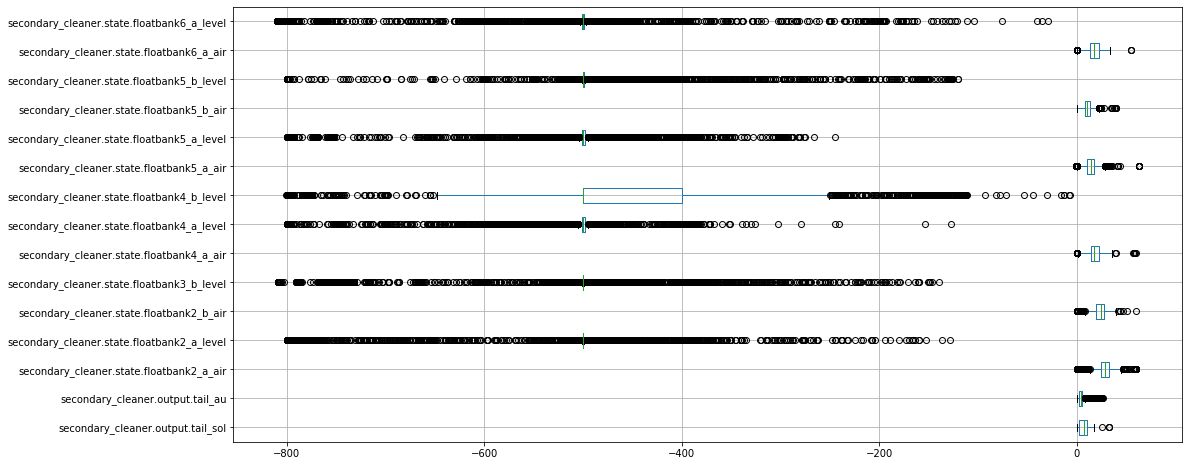

In [20]:
fig = plt.figure(figsize=(17,8))
df_full.boxplot(column=arr_col_secondary, vert=False)

_Посмотрим на график boxplot признаков на этапе первичной очистки(primary_cleaner) с выбросами в значениях_

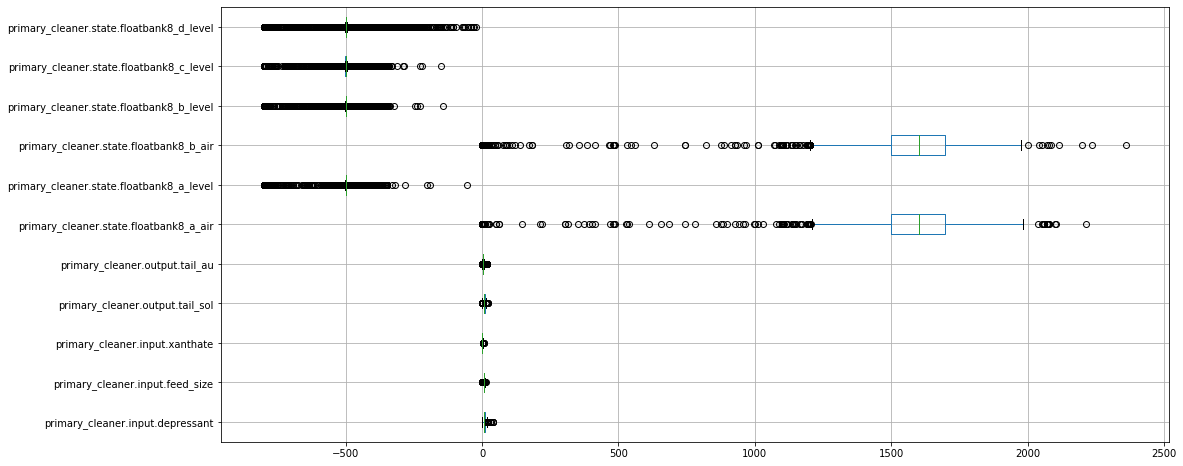

In [21]:
fig = plt.figure(figsize=(17,8))
df_full.boxplot(column=arr_col_primary, vert=False)

По двум выше графикам можно сказать, что на каждом этапе больше всего раброс значений и большее количество выбросов/экстремальных занчений имеют параметры связанные с уровем жидкости(fluid levels) и с объёмом воздуха(air amount)

_Посмотрим на график boxplot признаков со значениями fluid levels — уровня жидкости во флотационных машинах_

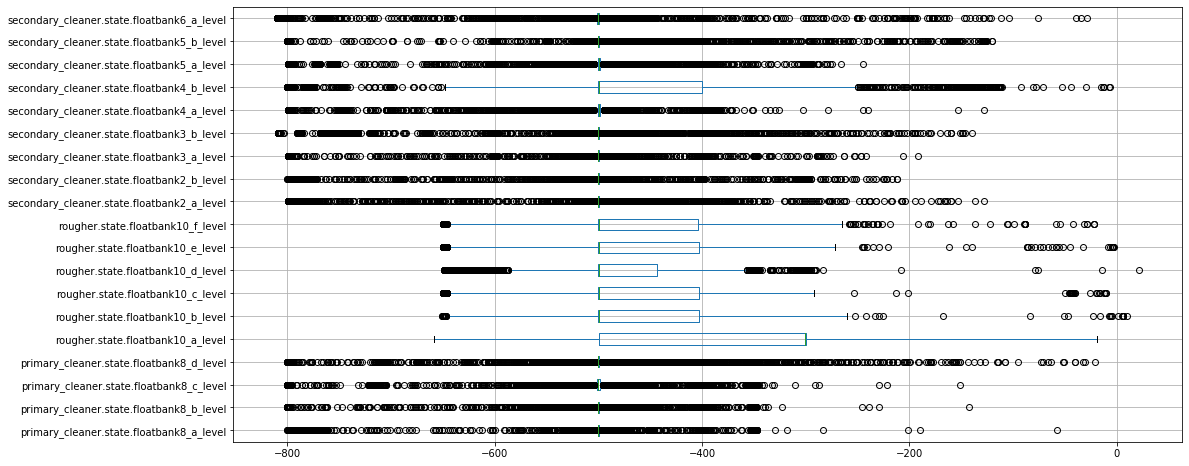

In [22]:
fig = plt.figure(figsize=(17,8))
df_full.boxplot(column=arr_filter_col(df_full.columns, 'level'), vert=False)

_Судя по графикам рапределения значений признаков, наблюдается очень большое количество значений-выбросов в таких признаках как fluid levels — уровень жидкости. Мы не знаем технологические особеннсоти процесса и границы допустимых значений для этих признаков, поэтом не можем их модифицировать. Просто отметим что это очень странно. Отметим, что медианна у всех этих признаков примерно совподают. Отметим, что показатели уровня житкости во флотационной машине №10 почти укладываются в правило 3 сигм. И посравнению с другими флотационными машинами, о флотационной машине №10 можно сказать, что её датчки работают корректно, она отколлиброванна. Но возможно всё дело в технологическом процессе о котором мы мало значем. Один из показателей уровня жидкости в во флотационной машине №4 похож на показатели во флотационной машине №10. И, поэтому я больше склоняюсь к отсутствию калибровки  уровня житкости во флотационных машинах, кроме машины №10._

_Посмотрим на график boxplot признаков со значениями air amount — объёма воздуха во флотационных машинах_

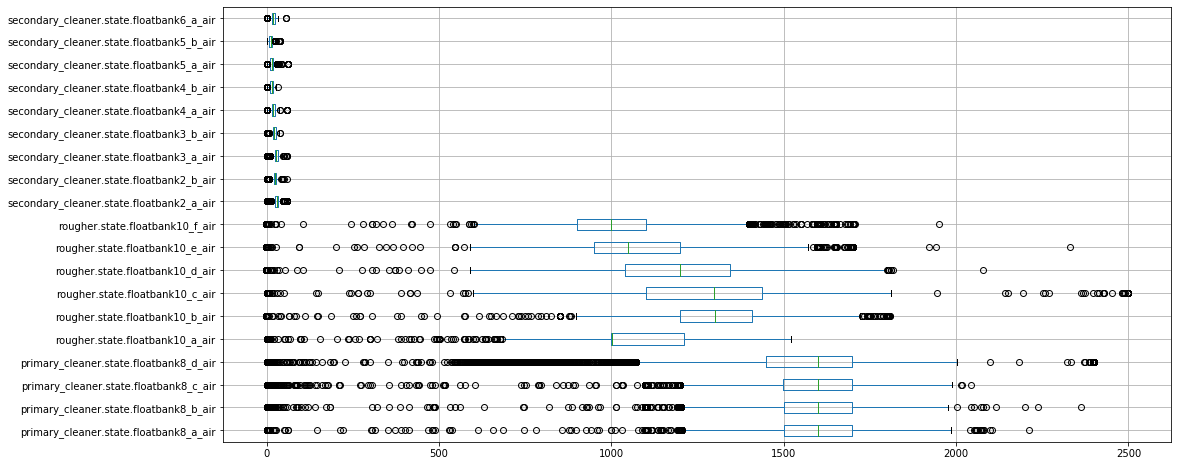

In [23]:
fig = plt.figure(figsize=(17,8))
df_full.boxplot(column=arr_filter_col(df_full.columns, 'air'), vert=False)

_Видно, что в разных флотационных машинах используется разный объём воздуха(air amount) в технологическом процессе, либо мы имеем дело с искажением данных с датчиков._

### Промежуточный вывод     <a class="anchor" id="first1-step"></a>

0. Главное, что бросается в глаза, это отсутствие единиц измерений для всех столбцов, кроме столбца **date**.
1. В данных присутствует досточно много пропущенных значений. В столбцах **rougher.output.recovery, rougher.output.tail_ag, rougher.output.tail_au и rougher.output.tail_sol** данные пропущены свыше 10%. В этих столбцах значения о параметрах продукта после флотации. Вероятно плохо измеряются характеристики полученного продукта, что очень странно для золотодобывающей компании. Где-то эти данные теряются. 
2. В столбцах **rougher.input.floatbank11_xanthate, secondary_cleaner.output.tail_sol, final.output.recovery, rougher.calculation.au_pb_ratio, primary_cleaner.input.sulfate, primary_cleaner.input.depressant, rougher.input.floatbank10_sulfate и primary_cleaner.input.xanthate** количество пропущеных занчение выше 5%, но ниже 10%.  
3. Так как столбцы **rougher.output.recovery и final.output.recovery** являются целевыми, то заполнять мы их не будем. мы их должны предсказывать по модели, следовательно строки с пропущенными данными в этих столбцах удалим  
4. Данные в gold_recovery_test.csv(тестовая выборка) и gold_recovery_train.csv(обучающая выборка) из gold_recovery_full.csv(исходные данные). 
5. Количество столбцов в gold_recovery_train.csv(обучающая выборка) столько же сколько и в gold_recovery_full.csv(исходные данные)
6. Количество столбцов в gold_recovery_test.csv(тестовая выборка) меньше, чем в gold_recovery_full.csv(исходные данные). Об этом чуть позже.  
7. Количество признаков на каждом этапе разное.  
        Количество признаков на этапе флотации(rougher) - 35  
        Количество признаков на этапе первичной очистки(primary_cleaner) - 20  
        Количество признаков на этапе вторичной очистки(secondary_cleaner) - 22  
        Количество признаков на финальном этапе(final) - 9  
8. Количество признаков в которых очень большие выбросы на каждом этапе больше 50% от общего количества признаков на этапе.
9. Судя по графикам рапределения значений признаков, наблюдается очень большое количество значений-выбросов в таких признаках как fluid levels — уровень жидкости. Мы не знаем технологические особеннсоти процесса и границы допустимых значений для этих признаков, поэтом не можем их модифицировать. Просто отметим что это очень странно. Отметим, что медианна у всех этих признаков примерно совподают. Отметим, что показатели уровня житкости во флотационной машине №10 почти укладываются в правило 3 сигм. И посравнению с другими флотационными машинами, о флотационной машине №10 можно сказать, что её датчки работают корректно, она отколлиброванна. Но возможно всё дело в технологическом процессе о котором мы мало значем.

Взгляним на графическое представление пропущенных данных

Text(0.5, 1, 'Пропущенные значения')

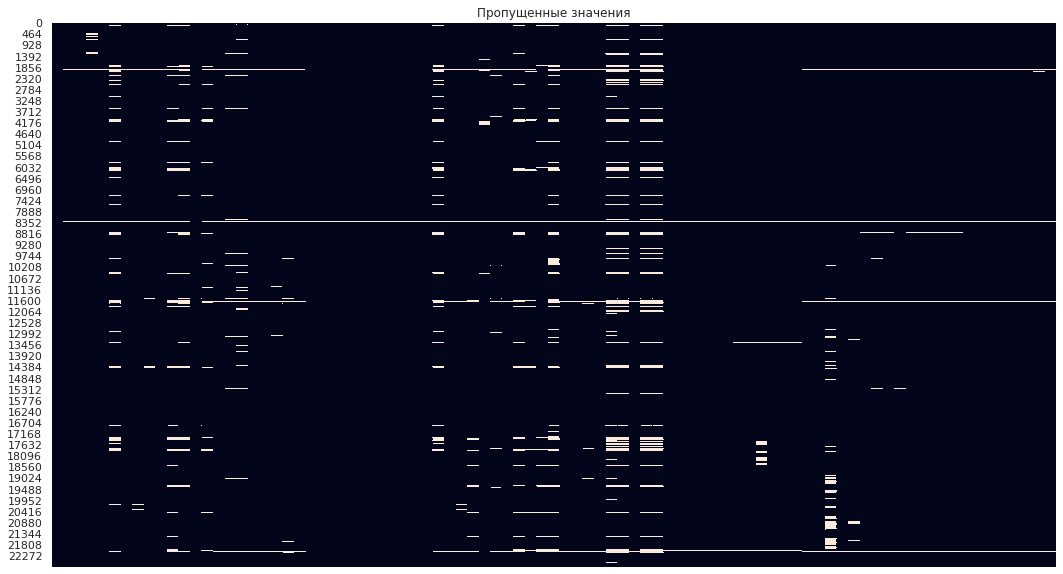

In [24]:
sns.set()
fig,ax = plt.subplots(figsize=(18,10)) 
sns.heatmap(df_full.isnull(), cbar = False, ax=ax, xticklabels = False).set_title("Пропущенные значения")

На графике видно, что за некоторые моменты времени данные, либо полностью, либо почти полностью  отсутствют - белые полосы  
Удалим строки с пустыми значениями в целевых признаках.

In [25]:
df_full.dropna(subset = ['rougher.output.recovery'], inplace = True)
df_full.dropna(subset = ['final.output.recovery'], inplace = True)
df_full = df_full.reset_index(drop=True)

_Нам данна подсказка как заполнять остальные пропущенные данные: "Соседние по времени параметры часто похожи.". Для этой цели воспользуемся методом ffill https://www.geeksforgeeks.org/python-pandas-dataframe-ffill/ и заполним пропущенные значения на значения рядом стоящие_

In [26]:
df_full = df_full.ffill(axis = 0) 

In [27]:
file_info_null(df_full)

                                                 name     type  NN_Count isnull
0                                                date   object     19439  0.00%
55                    rougher.state.floatbank10_b_air  float64     19439  0.00%
63                    rougher.state.floatbank10_f_air  float64     19439  0.00%
62                  rougher.state.floatbank10_e_level  float64     19439  0.00%
61                    rougher.state.floatbank10_e_air  float64     19439  0.00%
60                  rougher.state.floatbank10_d_level  float64     19439  0.00%
59                    rougher.state.floatbank10_d_air  float64     19439  0.00%
58                  rougher.state.floatbank10_c_level  float64     19439  0.00%
57                    rougher.state.floatbank10_c_air  float64     19439  0.00%
56                  rougher.state.floatbank10_b_level  float64     19439  0.00%
54                  rougher.state.floatbank10_a_level  float64     19439  0.00%
65                   secondary_cleaner.o

In [28]:
print('Пропущенных значений более нет. Было удалено примерно {:.1%} исходных данных'.format((22716 - 19439) / 22716))

Пропущенных значений более нет. Было удалено примерно 14.4% исходных данных


_Заметим, что столбец **date** имеет неправильный тип и его надо преобразовать. Потом сделаем из этого столбца индекс. ведь он не будет использован в алгоритмах обучения_  
_Удалим строки из тестовой выборки, которые мы удалили из изходных данных на основе значений в столбце **date**_

In [29]:
df_test = df_test[df_test['date'].isin(df_full['date'])]
df_test = df_test.reset_index(drop=True)

_Удалим строки из обучающей выборки, которые мы удалили из изходных данных на основе значений в столбце **date**_

In [30]:
df_train = df_train[df_train['date'].isin(df_full['date'])]
df_train = df_train.reset_index(drop=True)

In [31]:
file_info_null(df_test)

                                          name     type  NN_Count isnull
22          rougher.input.floatbank11_xanthate  float64      5265  0.47%
17                      rougher.input.feed_sol  float64      5269  0.40%
39    secondary_cleaner.state.floatbank3_a_air  float64      5281  0.17%
21           rougher.input.floatbank11_sulfate  float64      5282  0.15%
2             primary_cleaner.input.depressant  float64      5285  0.09%
19           rougher.input.floatbank10_sulfate  float64      5285  0.09%
4               primary_cleaner.input.xanthate  float64      5286  0.08%
1                primary_cleaner.input.sulfate  float64      5286  0.08%
15                     rougher.input.feed_rate  float64      5287  0.06%
35    secondary_cleaner.state.floatbank2_a_air  float64      5287  0.06%
37    secondary_cleaner.state.floatbank2_b_air  float64      5288  0.04%
16                     rougher.input.feed_size  float64      5289  0.02%
38  secondary_cleaner.state.floatbank2_b_level  flo

_Пропущенные значения заполним из соответствующих ячеек из исходных данных. Ведь там мы уже выполнили заполнение_

In [32]:
#df_full['date'] = df_full['date'].astype('datetime64[ns]')
#df_test['date'] = df_test['date'].astype('datetime64[ns]')
#df_train['date'] = df_train['date'].astype('datetime64[ns]')

In [33]:
df_full = df_full.set_index('date')
df_test = df_test.set_index('date')
df_train = df_train.set_index('date')

In [34]:
def fill_null_old(df):
    for col in df.columns: #по всем столбцам
        if df[col].isnull().sum() > 0 : #только для столбцов, где есть пропущенные значения
            for i in df.index: #range(0,df.shape[0]):
                try:
                    if math.isnan(df.loc[i,col]) : #если значение пропущенно
                        df.loc[i,col] = df_full.loc[i,col] #взять его из файла исходных данных
                except: df.loc[i,col] = np.nan
    return df
    

In [35]:
def fill_null(df):
    for col in df.columns: #по всем столбцам
        if df[col].isnull().sum() > 0 : #только для столбцов, где есть пропущенные значения
            index = df[df[col].isnull()].index
            df.loc[index,col] = df_full[df_full.index.isin(index)][col]
    return df

#### По условию проекта данные находятся в трёх файлах:  
<li>gold_recovery_train.csv — обучающая выборка;</li>
<li>gold_recovery_test.csv — тестовая выборка;</li>  
<li>gold_recovery_full.csv — исходные данные.</li> 
Данные индексируются датой и временем получения информации (признак date).
Файл gold_recovery_full.csv обозначен как исходные данные, и как бы подразумевается, что данные в файлах с обучающей и тестовой выборками взяты из файла с исходными данными. и даже сумма строк в обучающей и тестовой выборке равна числу строк в исходных данных.   

Но действительно ли это так?

In [36]:
print('Количество записей в файле с иходными данными', c_df_full)
print('Сумма записей в обучющей и тестовой выборках', c_df_test + c_df_train)

Количество записей в файле с иходными данными 22716
Сумма записей в обучющей и тестовой выборках 22716


In [37]:
print('Количество записей в обучающей выборке', df_test.shape)
print('количество записей ', df_full[df_full.index.isin(df_test.index)].shape[0])

Количество записей в обучающей выборке (5290, 52)
количество записей  5290


In [38]:
print('Количество записей в обучающей выборке', df_train.shape)
print('количество записей ', df_full[df_full.index.isin(df_train.index)].shape[0])

Количество записей в обучающей выборке (14149, 86)
количество записей  14149


In [39]:
df_test = fill_null(df_test)
df_train = fill_null(df_train)

In [40]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5290 entries, 2016-09-01 00:59:59 to 2017-12-31 23:59:59
Data columns (total 52 columns):
primary_cleaner.input.sulfate                 5290 non-null float64
primary_cleaner.input.depressant              5290 non-null float64
primary_cleaner.input.feed_size               5290 non-null float64
primary_cleaner.input.xanthate                5290 non-null float64
primary_cleaner.state.floatbank8_a_air        5290 non-null float64
primary_cleaner.state.floatbank8_a_level      5290 non-null float64
primary_cleaner.state.floatbank8_b_air        5290 non-null float64
primary_cleaner.state.floatbank8_b_level      5290 non-null float64
primary_cleaner.state.floatbank8_c_air        5290 non-null float64
primary_cleaner.state.floatbank8_c_level      5290 non-null float64
primary_cleaner.state.floatbank8_d_air        5290 non-null float64
primary_cleaner.state.floatbank8_d_level      5290 non-null float64
rougher.input.feed_ag                         529

In [41]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14149 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
final.output.concentrate_ag                           14149 non-null float64
final.output.concentrate_pb                           14149 non-null float64
final.output.concentrate_sol                          14149 non-null float64
final.output.concentrate_au                           14149 non-null float64
final.output.recovery                                 14149 non-null float64
final.output.tail_ag                                  14149 non-null float64
final.output.tail_pb                                  14149 non-null float64
final.output.tail_sol                                 14149 non-null float64
final.output.tail_au                                  14149 non-null float64
primary_cleaner.input.sulfate                         14149 non-null float64
primary_cleaner.input.depressant                      14149 non-null float64
primary_cleaner.i

_Удалил и заполнили пропущенные данные во всех трёх наборах данных_  
#### _Проанализируем признаки, недоступные в тестовой выборке. Что это за параметры? К какому типу относятся?_

In [42]:
pd.set_option('display.max_rows', 100)
test_diff_columns = diff_columns(df_test) #Сохраним список столбцов. пригодится вдальнейшем для удаления
test_diff_columns

15                          final.output.concentrate_ag
33                          final.output.concentrate_au
0                           final.output.concentrate_pb
1                          final.output.concentrate_sol
10                                final.output.recovery
3                                  final.output.tail_ag
14                                 final.output.tail_au
30                                 final.output.tail_pb
6                                 final.output.tail_sol
25                primary_cleaner.output.concentrate_ag
7                 primary_cleaner.output.concentrate_au
13                primary_cleaner.output.concentrate_pb
27               primary_cleaner.output.concentrate_sol
32                       primary_cleaner.output.tail_ag
11                       primary_cleaner.output.tail_au
22                       primary_cleaner.output.tail_pb
31                      primary_cleaner.output.tail_sol
21                      rougher.calculation.au_p

_В тестовой выборке отсутствуют признаки параметры продукта  и расчётные характеристики для всех этапов.  
Посути мы их должны предсказать с помощью модели, либо они высчитываются с помощью формул_

In [43]:
df_test[diff_columns(df_test)] = df_full[diff_columns(df_test)]

##### Расчёт эффективности
Вам нужно смоделировать процесс восстановления золота из золотосодержащей руды.  
Эффективность обогащения рассчитывается по формуле  
Recovery = (C * (F - T ) )/(F * (C - T)) * 100%  
где:  
C — доля золота в концентрате после флотации/очистки;  
F — доля золота в сырье/концентрате до флотации/очистки;  
T — доля золота в отвальных хвостах после флотации/очистки.  

In [44]:
def recovery_gold(df, df_c, df_f, df_t):
    C = df[df_c]
    F = df[df_f]
    T = df[df_t]
    try:
        RC = (C * (F - T ) )/(F * (C - T)) * 100
    except ZeroDivisionError:
        RC = 0
    return RC

df_calc = pd.DataFrame(columns = ['rougher.output.recovery_calc'])
df_calc['rougher.output.recovery_calc'] = df_train.apply(
    recovery_gold, df_c = 'rougher.output.concentrate_au', 
                  df_f = 'rougher.input.feed_au', df_t = 'rougher.output.tail_au', axis = 1)

In [45]:
df_calc['rougher.output.recovery_calc'].isnull().sum()

0

In [46]:
print('Медиана {:.2f}'.format(df_train['rougher.output.recovery'].median()))
print('Среднее {:.2f}'.format(df_train['rougher.output.recovery'].mean()))

Медиана 85.30
Среднее 82.70


In [49]:
print('MAE =  {:.30f}'.format(mean_squared_error(df_train['rougher.output.recovery'], 
                                                 df_calc['rougher.output.recovery_calc'])))

MAE =  0.000000000000000000000000000205


In [50]:
print('RMSE =  {:.30f}'.format(
    mean_squared_error(df_train['rougher.output.recovery'], df_calc['rougher.output.recovery_calc'], squared = False)))

TypeError: mean_squared_error() got an unexpected keyword argument 'squared'

Вычислили эффективность обогащения на обучающей выборке для признака rougher.output.recovery.  
rougher — флотация  
rougher.output.concentrate_au - C — доля золота в концентрате после флотации/очистки;  
rougher.input.feed_au - F — доля золота в сырье/концентрате до флотации/очистки  
rougher.output.tail_au - T — доля золота в отвальных хвостах после флотации/очистки.  
Итого, мы получаем MAE очень близкое к нулю. Формула достачно точно предсказывает процесс восстановления золота из золотосодержащей руды.

In [51]:
c_df_full_after1 = df_full.shape[0] #количество записей в исходном наборе после удаления данных
c_df_test_after1 = df_test.shape[0] #количество записей в тестовой выборке после удаления данных
c_df_train_after1 = df_train.shape[0] #количество записей в обучающей выборке после удаления данных

In [52]:
print('Было удалено примерно {:.1%} исходных данных сначала проекта'.format(
    (c_df_full - c_df_full_after1) / c_df_full))
print('Было удалено примерно {:.1%} тестовой выборки сначала проекта'.format(
    (c_df_test - c_df_test_after1) / c_df_test))
print('Было удалено примерно {:.1%} обучающей выборки сначала проекта'.format(
    (c_df_train - c_df_train_after1) / c_df_train))

Было удалено примерно 14.4% исходных данных сначала проекта
Было удалено примерно 9.7% тестовой выборки сначала проекта
Было удалено примерно 16.1% обучающей выборки сначала проекта


### Вывод <a class="anchor" id="first-conclusion"></a>

<u>Напомним, что требовалось в этом разделе
    <li>1.1. Откройте файлы и изучите их. </li>
    <li>1.2. Проверьте, что эффективность обогащения рассчитана правильно. Вычислите её на обучающей выборке для признака rougher.output.recovery. Найдите MAE между вашими расчётами и значением признака. Опишите выводы.</li>
    <li>1.3. Проанализируйте признаки, недоступные в тестовой выборке. Что это за параметры? К какому типу относятся?</li>
    <li>1.4. Проведите предобработку данных.</li>
</u>

Все указанные пункты выполнили. Выводы сделаны по ходу предобработки данных. Кратко их сюда продублируем.

1. Главное, что бросается в глаза, это отсутствие единиц измерений для всех столбцов, кроме столбца date.
2. Количество признаков в которых очень большие выбросы на каждом этапе больше 50% от общего количества признаков на этапе.
3. Судя по графикам рапределения значений признаков, наблюдается очень большое количество значений-выбросов в таких признаках как fluid levels — уровень жидкости. Мы не знаем технологические особеннсоти процесса и границы допустимых значений для этих признаков, поэтом не можем их модифицировать. Просто отметим что это очень странно. Отметим, что медианна у всех этих признаков примерно совподают. Отметим, что показатели уровня житкости во флотационной машине №10 почти укладываются в правило 3 сигм. И посравнению с другими флотационными машинами, о флотационной машине №10 можно сказать, что её датчки работают корректно, она отколлиброванна. Но возможно всё дело в технологическом процессе о котором мы мало значем. Один из показателей уровня жидкости в во флотационной машине №4 похож на показатели во флотационной машине №10. И, поэтому я больше склоняюсь к отсутствию калибровки уровня житкости во флотационных машинах, кроме машины №10.
4. За некоторые моменты времени данные, либо полностью, либо почти полностью отсутствют.
5. Удалили строки с пустыми значениями в целевых признаках. Удалили 14.4% исходного набора данных.
6. Вычилили эфективность восстановления золота из золотосодержащей руды по представленной в проекте формуле. Расхождение между значением предсказанным по формуле и фактическим почти равно нулю.
7. В тестовой выборке отсутствуют признаки параметры продукта и расчётные характеристики для всех этапов.

# 2. Анализ данных     <a class="anchor" id="second-step"></a>

2.1. Посмотрите, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки. Опишите выводы.  
2.2. Сравните распределения размеров гранул сырья на обучающей и тестовой выборках. Если распределения сильно отличаются друг от друга, оценка модели будет неправильной.  
2.3. Исследуйте суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах. Заметили аномальные значения в суммарном распределении или нет? Если они есть, стоит ли их удалять из обеих выборок? Опишите выводы и удалите аномалии.

* [2.1 Промежуточный вывод](#second21-conclusion)
* [2.2 Промежуточный вывод](#second22-conclusion)
* [2.3 Промежуточный вывод](#second23-conclusion)

Возможные значения для блока [этап]:  
rougher — флотация  
primary_cleaner — первичная очистка  
secondary_cleaner — вторичная очистка  
final — финальные характеристики  

In [53]:
def col_substr(arr):
    arr_tmp = []
    for d in arr:
        if 'rougher.input' in d:
            arr_tmp.append('сырье')        
        if 'rougher.output' in d:
            arr_tmp.append('флотация')
        if 'primary_cleaner' in d:
            arr_tmp.append('первичная очистка')
        if 'secondary_cleaner' in d:
            arr_tmp.append('вторичная очистка')
        if 'final' in d:
            arr_tmp.append('финальный этап')  
    return arr_tmp

In [54]:
def step2_1(df, filter1, filter2, filter3, title1, title2, title3, title4, angle):

    fig = plt.figure(figsize=(17,6))
    ax1 = fig.add_subplot(1,3,1)
    g1 = sns.boxplot(data=df[arr_filter_col(df, filter1)], palette="Set2")    
    ax1.set_xticklabels(labels = col_substr(arr_filter_col(df, filter1)), rotation=angle, size=14)
    plt.title(title2, size=18)

    ax2 = fig.add_subplot(1,3,2, sharey=ax1)
    g2 = sns.boxplot(data=df[arr_filter_col(df, filter2)], palette="Set2")
    ax2.set_xticklabels(labels = col_substr(arr_filter_col(df, filter2)), rotation=angle, size=14)    
    plt.title(title3, size=18)
    
    ax3 = fig.add_subplot(1,3,3, sharey=ax1)
    g2 = sns.boxplot(data=df[arr_filter_col(df, filter3)], palette="Set2")
    ax3.set_xticklabels(labels = col_substr(arr_filter_col(df, filter3)), rotation=angle, size=14)    
    plt.title(title4, size=18)
   
    plt.suptitle(title1, size=22)
    plt.show()

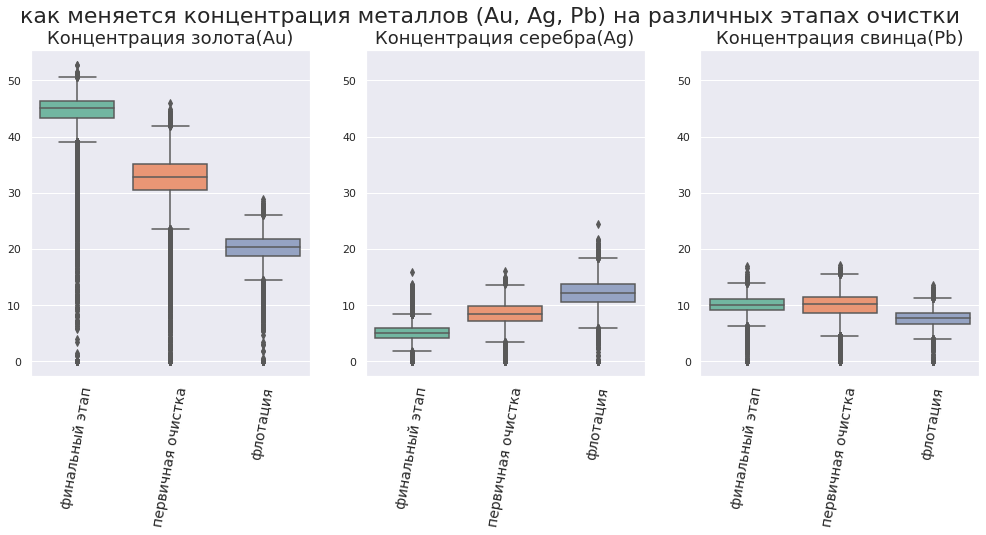

In [55]:
title = 'как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки'
step2_1(df_full, 
        'concentrate_au', 'concentrate_ag', 'concentrate_pb',title,
        'Концентрация золота(Au)', 'Концентрация серебра(Ag)', 'Концентрация свинца(Pb)', 80)

#### Промежуточный вывод 2.1 <a class="anchor" id="second21-conclusion"></a>

Доля золота увеличивается в среднем в два раза от этапа флотации к финальному этапу.   
Доля серебра, наоборт, уменьшается от этапа флотации к финальному этапу.   
Доля свинца немного увеличивается после этапа флотации, и незначительно меняется от этапа первичной очистки к финальному этапу.

### Сравним распределения размеров гранул сырья на обучающей и тестовой выборках.

In [56]:
arr_filter_col(df_full, 'size')

['primary_cleaner.input.feed_size', 'rougher.input.feed_size']

Есть всего два столбца со значениями о размере гранул. Это столбец **rougher.input.feed_size**, в котором значения о размере гранул сырья на этапе флотации. И, столбец **primary_cleaner.input.feed_size**, в котором значения о размере гранул сырья на этапе первичной очистки.

In [57]:
def step2_2(title1):

    fig = plt.figure(figsize=(17,6))
    ax1 = fig.add_subplot(1,2,1)
    g1 = sns.boxplot(data=df_train[arr_filter_col(df_train, 'size')], palette="Set2")
    ax1.set_xticklabels(labels = col_substr(arr_filter_col(df_train, 'size')), rotation=45, size=14)    
    plt.title('Размер гранул на обучающей выборке', size=18)    

    ax2 = fig.add_subplot(1,2,2, sharey=ax1)
    g2 = sns.boxplot(data=df_test[arr_filter_col(df_test, 'size')], palette="Set2")   
    ax2.set_xticklabels(labels = col_substr(arr_filter_col(df_test, 'size')), rotation=45, size=14)     
    plt.title('Размер гранул на тестовой выборке', size=18)    
    
    plt.suptitle(title1, size=22)
    plt.show()

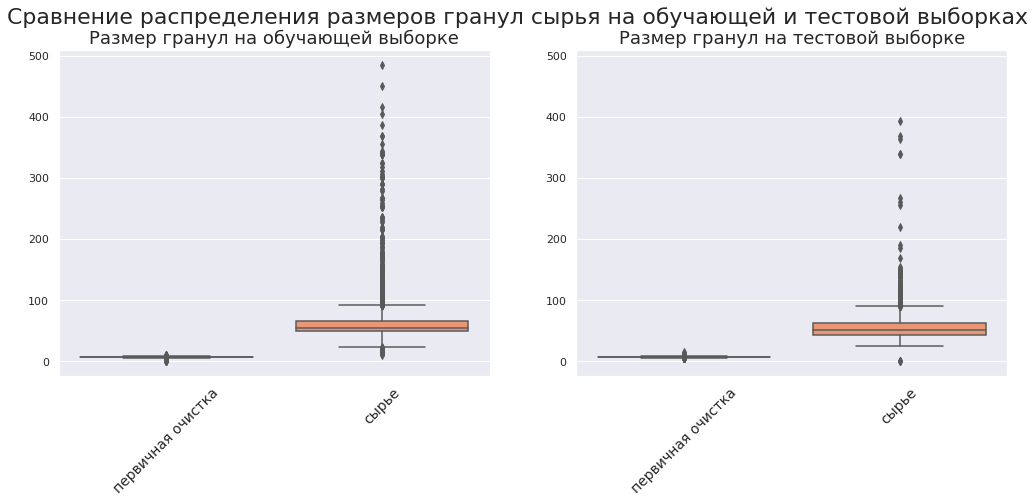

In [58]:
title = 'Сравнение распределения размеров гранул сырья на обучающей и тестовой выборках'
step2_2(title)

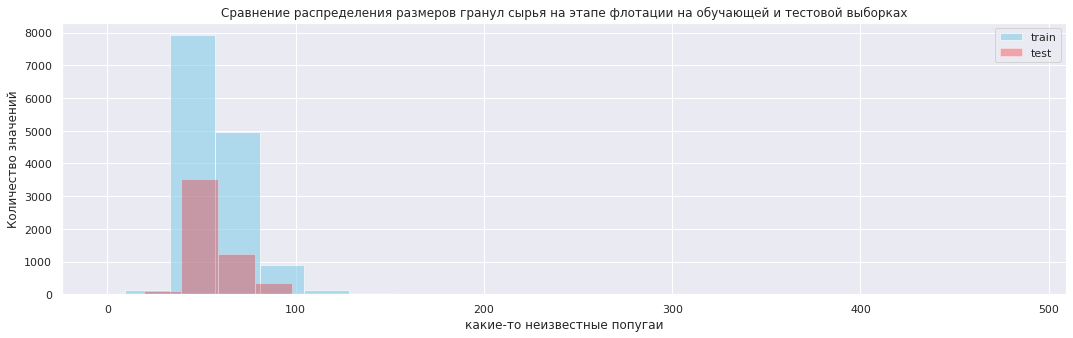

In [59]:
def distplot2_2(df1, df2, label1, lable2, title):
    fig = plt.figure(figsize=(18,5))
    plt.title(title)
    sns.distplot(df1, bins = 20 ,kde = False, color="skyblue",  label=label1, hist_kws = {'alpha' :0.6})  
    sns.distplot(df2, bins = 20 ,kde = False, color="red",  label=lable2, hist_kws = {'alpha' :0.3}) 
    plt.ylabel('Количество значений')
    plt.xlabel('какие-то неизвестные попугаи')
    plt.legend()
    plt.show()
    

distplot2_2(df_train['rougher.input.feed_size'],
            df_test['rougher.input.feed_size'], 'train', 'test',
           'Сравнение распределения размеров гранул сырья на этапе флотации на обучающей и тестовой выборках')

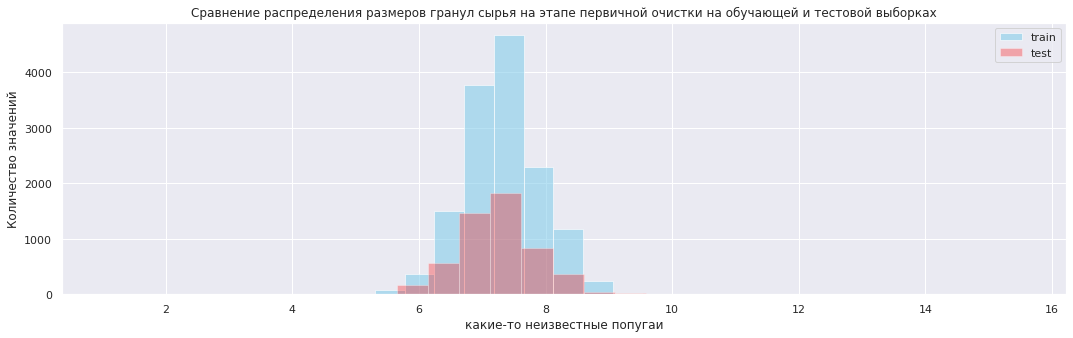

In [60]:
distplot2_2(df_train['primary_cleaner.input.feed_size'],
            df_test['primary_cleaner.input.feed_size'], 'train', 'test',
           'Сравнение распределения размеров гранул сырья на этапе первичной очистки на обучающей и тестовой выборках')

In [61]:
def proverka_hypotizy(sample_1,sample_2):
    alpha = .05 # критический уровень статистической значимости
                # если p-value окажется меньше него - отвергнем гипотезу

    results = st.ttest_ind(sample_1, sample_2, equal_var = True)
    print('p-значение: {:.2%}'.format(results.pvalue))

    if (results.pvalue < alpha):
        print("Отвергаем нулевую гипотезу")
    else:
        print("Не получилось отвергнуть нулевую гипотезу")

Начнём с формулировки нулевой гипотезы H₀. H₀ всегда формулируется так, чтобы использовать знак равенства.
В нашем случае гипотезы H₀ будет звучать так:
<blockquote>Средний размер гранул сырья на обучающей и тестовой выборках не различаются</blockquote>

Исходя из H₀ формулируется альтернативная гипотеза H₁. Для этой H₀ она звучит как «среднее генеральной совокупности не равно A». В нашем случае гипотезы H₁ будет звучать так:
<blockquote>Средний размер гранул сырья на обучающей и тестовой выборках различаются</blockquote>

In [62]:
proverka_hypotizy(df_train['rougher.input.feed_size'],df_test['rougher.input.feed_size'])

p-значение: 0.00%
Отвергаем нулевую гипотезу


In [63]:
proverka_hypotizy(df_train['primary_cleaner.input.feed_size'],df_test['primary_cleaner.input.feed_size'])

p-значение: 0.00%
Отвергаем нулевую гипотезу


In [64]:
def print_mean_interval(values, title):
    print(title)
    print('Cредний размер равен : {:20,.0f} '.format(values.mean()))
    confidence_interval = st.t.interval( 0.95, values.size-1, loc = values.mean() , scale = values.sem()) 
    print('95%-ый доверительный интервал: {:20,.0f} -{:20,.0f}'.format(confidence_interval[0], confidence_interval[1]))

In [65]:
print_mean_interval(df_train['rougher.input.feed_size'], 'Данные из обучающей выборки на этапе флотации')

Данные из обучающей выборки на этапе флотации
Cредний размер равен :                   60 
95%-ый доверительный интервал:                   60 -                  61


In [66]:
print_mean_interval(df_test['rougher.input.feed_size'], 'Данные из тестовой выборки на этапе флотации')

Данные из тестовой выборки на этапе флотации
Cредний размер равен :                   56 
95%-ый доверительный интервал:                   55 -                  56


In [67]:
print_mean_interval(df_train['primary_cleaner.input.feed_size'], 'Данные из обучающей выборки на этапе первичной очистки')

Данные из обучающей выборки на этапе первичной очистки
Cредний размер равен :                    7 
95%-ый доверительный интервал:                    7 -                   7


In [68]:
print_mean_interval(df_test['primary_cleaner.input.feed_size'], 'Данные из тестовой выборки на этапе первичной очистки')

Данные из тестовой выборки на этапе первичной очистки
Cредний размер равен :                    7 
95%-ый доверительный интервал:                    7 -                   7


#### Промежуточный вывод 2.2 <a class="anchor" id="second22-conclusion"></a>

1. Средний размер гранул сырья на обучающей и тестовой выборках различаются
2. Хотя, если посмотреть на гистограммы распределения размера гранул сырья на обучающей и тестовой выборках, и не скажешь о их раличиях.
3. Распределение размера гранул сырья перед этапом флотации похоже на распределение Пуассона
4. Распределение размера гранул сырья перед этапом первичной очистки похоже на нормальное распределение.
5. Средний размер гранул сырья на обучающей и тестовой выборках различаются перед этапом флотации. Средние разные и доверительные интервалы разные. В дальнейшем модель машинного алгоритма покажет разные характеристики на обучающей и тестовых выборках.
6. Средний размер гранул сырья на обучающей и тестовой выборках различаются перед этапом первичной очистки. Хотя средние равны и доверительные интервалы равны. Странно.
7. Размер гранул от флотации до первичной очистики значительно уменьшается.

### Исследуйте суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах.

In [69]:
a1 = arr_filter_col(df_full, 'concentrate_') + arr_filter_col(df_full, 'feed_')
cleaned_list = list(filter(lambda x: ('primary_cleaner' not in x), a1))
cleaned_list = list(filter(lambda x: ('_size' not in x), cleaned_list))
cleaned_list = list(filter(lambda x: ('_rate' not in x), cleaned_list))
cleaned_list

['final.output.concentrate_ag',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.concentrate_au',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.concentrate_au',
 'rougher.input.feed_ag',
 'rougher.input.feed_pb',
 'rougher.input.feed_sol',
 'rougher.input.feed_au']

Итак, имеем четыре элемента Ag(Сереборо), Au(Золото), Pb(Свинец) и Sol("философский камень").  
rougher.input - показатели сырья.  
rougher.output - показатели после флотации, т.е. черновой концентрат.  
final.output - показатели финального продукта

In [70]:
def sum_columns(df , columns):
    sum_tmp = 0
    for col in columns:
        sum_tmp = sum_tmp + df[col]
    return sum_tmp        

In [71]:
df_concentrate = df_full[cleaned_list].copy()
df_concentrate['final_sum'] = df_concentrate.apply(sum_columns, 
                                                    columns = arr_filter_col(df_concentrate, 'final'), axis = 1 )
df_concentrate['rougher.output_sum'] = df_concentrate.apply(sum_columns, 
                                                    columns = arr_filter_col(df_concentrate, 'rougher.output'), axis = 1 )
df_concentrate['rougher.input_sum'] = df_concentrate.apply(sum_columns, 
                                                    columns = arr_filter_col(df_concentrate, 'rougher.input'), axis = 1 )

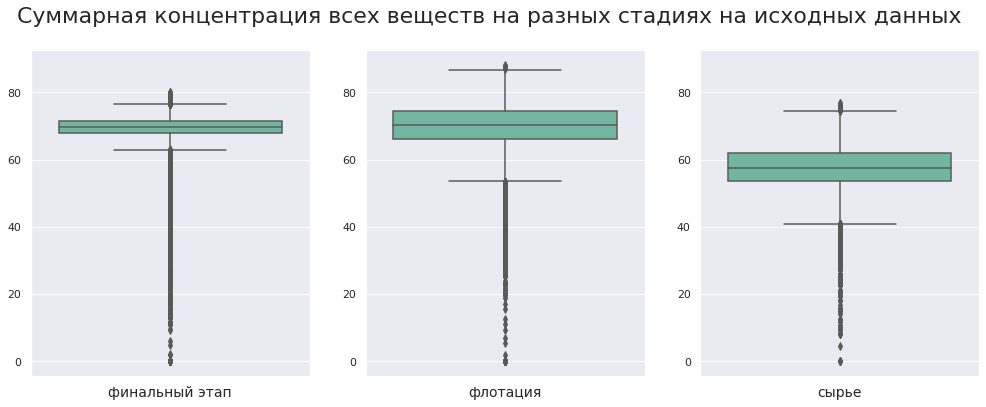

In [72]:
title = 'Суммарная концентрация всех веществ на разных стадиях на исходных данных'
step2_1(df_concentrate, 'final_sum', 'rougher.output_sum', 'rougher.input_sum',title, '','','', 0)

In [73]:
df_concentrate_test = df_test[cleaned_list].copy()
df_concentrate_test['final_sum'] = df_concentrate_test.apply(sum_columns, 
                                                    columns = arr_filter_col(df_concentrate_test, 'final'), axis = 1 )
df_concentrate_test['rougher.output_sum'] = df_concentrate_test.apply(sum_columns, 
                                                    columns = arr_filter_col(df_concentrate_test, 'rougher.output'), axis = 1 )
df_concentrate_test['rougher.input_sum'] = df_concentrate_test.apply(sum_columns, 
                                                    columns = arr_filter_col(df_concentrate_test, 'rougher.input'), 
                                                                       axis = 1 )

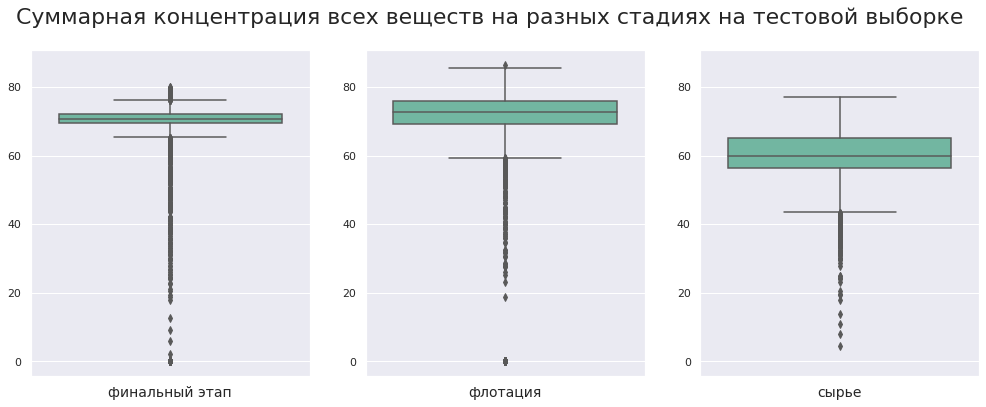

In [74]:
title = 'Суммарная концентрация всех веществ на разных стадиях на тестовой выборке'
step2_1(df_concentrate_test, 'final_sum', 'rougher.output_sum', 'rougher.input_sum',title, '','','', 0)

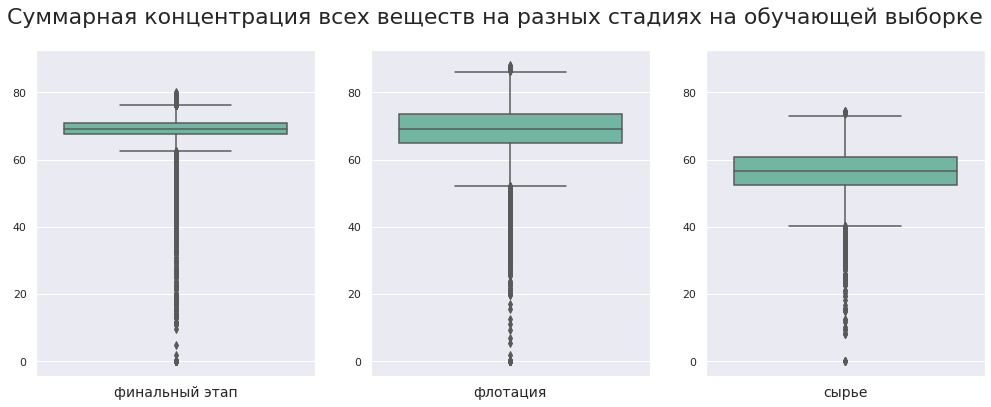

In [75]:
df_concentrate_train = df_train[cleaned_list].copy()
df_concentrate_train['final_sum'] = df_concentrate_train.apply(sum_columns, 
                                                    columns = arr_filter_col(df_concentrate_train, 'final'), axis = 1 )
df_concentrate_train['rougher.output_sum'] = df_concentrate_train.apply(sum_columns, 
                                                    columns = arr_filter_col(df_concentrate_train, 'rougher.output'), axis = 1 )
df_concentrate_train['rougher.input_sum'] = df_concentrate_train.apply(sum_columns, 
                                                    columns = arr_filter_col(df_concentrate_train, 'rougher.input'), 
                                                                       axis = 1 )
title = 'Суммарная концентрация всех веществ на разных стадиях на обучающей выборке'
step2_1(df_concentrate_train, 'final_sum', 'rougher.output_sum', 'rougher.input_sum',title, '','','', 0)

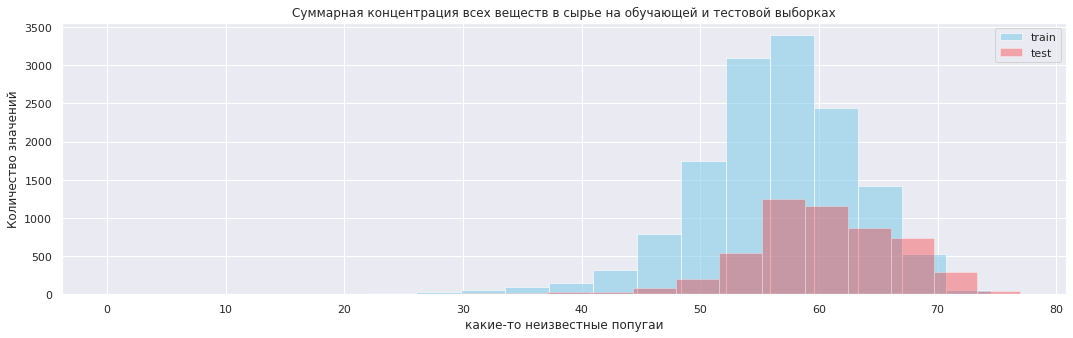

In [76]:
distplot2_2(df_concentrate_train['rougher.input_sum'],
            df_concentrate_test['rougher.input_sum'], 'train', 'test',
           'Суммарная концентрация всех веществ в сырье на обучающей и тестовой выборках')

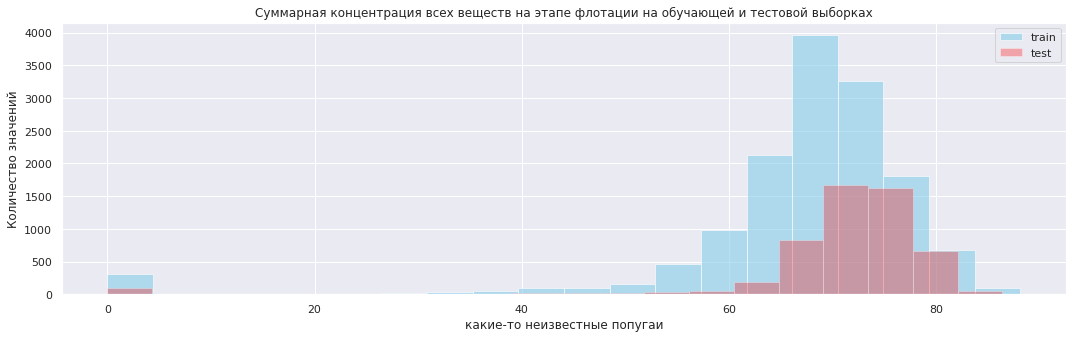

In [77]:
distplot2_2(df_concentrate_train['rougher.output_sum'],
            df_concentrate_test['rougher.output_sum'], 'train', 'test',
           'Суммарная концентрация всех веществ на этапе флотации на обучающей и тестовой выборках')

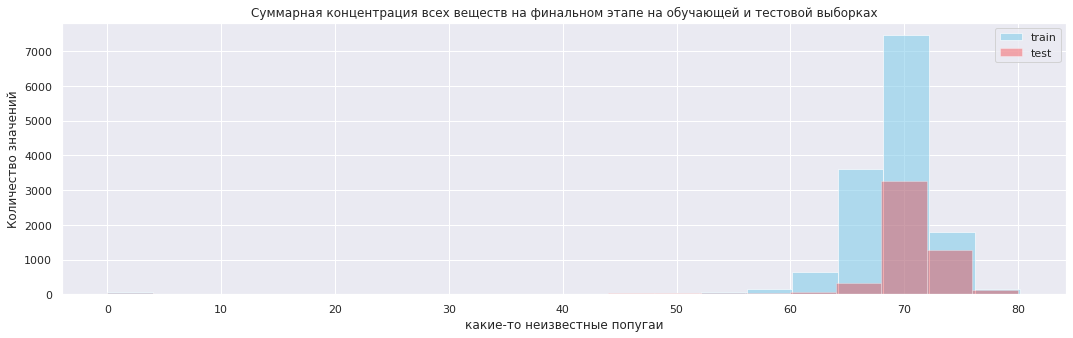

In [78]:
distplot2_2(df_concentrate_train['final_sum'],
            df_concentrate_test['final_sum'], 'train', 'test',
           'Суммарная концентрация всех веществ на финальном этапе на обучающей и тестовой выборках')

In [79]:
proverka_hypotizy(df_concentrate_train['rougher.output_sum'],df_concentrate_test['rougher.output_sum'])

p-значение: 0.00%
Отвергаем нулевую гипотезу


In [80]:
print_mean_interval(df_concentrate_test['rougher.output_sum'], 'Данные из тестовой выборки на этапе после флотации')

Данные из тестовой выборки на этапе после флотации
Cредний размер равен :                   71 
95%-ый доверительный интервал:                   71 -                  71


In [81]:
print_mean_interval(df_concentrate_train['rougher.output_sum'], 'Данные из обучающей выборки на этапе после флотации')

Данные из обучающей выборки на этапе после флотации
Cредний размер равен :                   67 
95%-ый доверительный интервал:                   67 -                  67


In [82]:
proverka_hypotizy(df_concentrate_train['final_sum'],df_concentrate_test['final_sum'])

p-значение: 0.00%
Отвергаем нулевую гипотезу


In [83]:
print_mean_interval(df_concentrate_test['final_sum'], 'Данные из тестовой выборки на финальном этапе')

Данные из тестовой выборки на финальном этапе
Cредний размер равен :                   69 
95%-ый доверительный интервал:                   69 -                  70


In [84]:
print_mean_interval(df_concentrate_train['final_sum'], 'Данные из обучающей выборки на финальном этапе')

Данные из обучающей выборки на финальном этапе
Cредний размер равен :                   68 
95%-ый доверительный интервал:                   68 -                  69


#### Промежуточный вывод 2.3 <a class="anchor" id="second23-conclusion"></a>

1. На графиках видно, что есть нулевые значения суммы концентрация всех веществ на каждом этапе. Вероятно это неправильно. И такие данные нужно удалить, как данные содержащие ошибку.
2. Большие хвосты выбросов - экстремально минимальных значений. Но так как мы не знаем допустимые границы этого параметра или возможности измеряющих приборов в технологическом процессе, то и удалять такие выбросы мы не можем.

In [85]:
def filter2_3(df, columns):
    filter_train = (df[columns[0]] + df[columns[1]] + df[columns[2]] + df[columns[3]] > 0)
    return filter_train

def remove_concentrate_sum_zero(df):
    df = df.where(filter2_3(df, list(filter(lambda x: ('rougher.input' in x), cleaned_list))))
    df = df.where(filter2_3(df, list(filter(lambda x: ('rougher.output' in x), cleaned_list))))
    df = df.where(filter2_3(df, list(filter(lambda x: ('final.output' in x), cleaned_list))))
    df = df.dropna()
    return df

Удалим записи для которых суммы концентрация всех веществ на каждом этапе равно нулю

In [86]:
c_df_full_before = df_full.shape[0] #количество записей в исходном наборе до удаления ошибочных данных
c_df_test_before = df_test.shape[0] #количество записей в тестовой выборке до удаления ошибочных данных
c_df_train_before = df_train.shape[0] #количество записей в обучающей выборке до удаления ошибочных данных

In [87]:
c_df_full_before

19439

In [88]:
c_df_test_before+c_df_train_before

19439

In [89]:
df_full1 = remove_concentrate_sum_zero(df_full)
df_test1 = remove_concentrate_sum_zero(df_test)
df_train1 = remove_concentrate_sum_zero(df_train)

In [90]:
c_df_full_after = df_full1.shape[0] #количество записей в исходном наборе после удаления ошибочных данных
c_df_test_after = df_test1.shape[0] #количество записей в тестовой выборке после удаления ошибочных данных
c_df_train_after = df_train1.shape[0] #количество записей в обучающей выборке после удаления ошибочных данных

In [91]:
print('Ошибочных значений нет. Было удалено примерно {:.1%} исходных данных'.format(
    (c_df_full_before - c_df_full_after) / c_df_full_before))
print('Ошибочных значений нет. Было удалено примерно {:.1%} тестовой выборки'.format(
    (c_df_test_before - c_df_test_after) / c_df_test_before))
print('Ошибочных значений нет. Было удалено примерно {:.1%} обучающей выборки'.format(
    (c_df_train_before - c_df_train_after) / c_df_train_before))

Ошибочных значений нет. Было удалено примерно 2.5% исходных данных
Ошибочных значений нет. Было удалено примерно 2.6% тестовой выборки
Ошибочных значений нет. Было удалено примерно 2.5% обучающей выборки


In [92]:
print('Было удалено примерно {:.1%} исходных данных сначала проекта'.format(
    (c_df_full - c_df_full_after) / c_df_full))
print('Было удалено примерно {:.1%} тестовой выборки сначала проекта'.format(
    (c_df_test - c_df_test_after) / c_df_test))
print('Было удалено примерно {:.1%} обучающей выборки сначала проекта'.format(
    (c_df_train - c_df_train_after) / c_df_train))

Было удалено примерно 16.6% исходных данных сначала проекта
Было удалено примерно 12.0% тестовой выборки сначала проекта
Было удалено примерно 18.2% обучающей выборки сначала проекта


In [93]:
c_df_full_after

18949

In [94]:
c_df_test_after+c_df_train_after

18949

### Вывод <a class="anchor" id="second-conclusion"></a>

#### Задача 2.1. Посмотрите, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки. Опишите выводы.
1. Доля золота увеличивается в среднем в два раза от этапа флотации к финальному этапу.  
2. Доля серебра, наоборт, уменьшается от этапа флотации к финальному этапу.  
3. Доля свинца немного увеличивается после этапа флотации, и незначительно меняется от этапа первичной очистки к финальному этапу.  

#### 2.2. Сравните распределения размеров гранул сырья на обучающей и тестовой выборках. Если распределения сильно отличаются друг от друга, оценка модели будет неправильной.  
1. Средний размер гранул сырья на обучающей и тестовой выборках различаются
2. Хотя, если посмотреть на гистограммы распределения размера гранул сырья на обучающей и тестовой выборках, и не скажешь о их раличиях.
3. Распределение размера гранул сырья перед этапом флотации похоже на распределение Пуассона
4. Распределение размера гранул сырья перед этапом первичной очистки похоже на нормальное распределение.
5. Средний размер гранул сырья на обучающей и тестовой выборках различаются перед этапом флотации. Средние разные и доверительные интервалы разные. В дальнейшем модель машинного алгоритма покажет разные характеристики на обучающей и тестовых выборках.
6. Средний размер гранул сырья на обучающей и тестовой выборках различаются перед этапом первичной очистки. Хотя средние равны и доверительные интервалы равны. Странно.
7. Размер гранул от флотации до первичной очистики значительно уменьшается.  
  
##### 2.3. Исследуйте суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах. Заметили аномальные значения в суммарном распределении или нет? Если они есть, стоит ли их удалять из обеих выборок? Опишите выводы и удалите аномалии.  
1. На графиках видно, что есть нулевые значения суммы концентрация всех веществ на каждом этапе. Вероятно это неправильно. И такие данные нужно удалить, как данные содержащие ошибку.  
2. Большие хвосты выбросов - экстремально минимальных значений. Но так как мы не знаем допустимые границы этого параметра или возможности измеряющих приборов в технологическом процессе, то и удалять такие выбросы мы не можем.  

Итого мы удалили почти пятую часть исходных данных. И это при том, что нам очень мало известно данных, отсутствуют единицы измерений, допустимые диапозоны показателей и тд. И это мы не удаляли экстремальные значения и выборосы. Очевидно, что данные очень сырые. Придётся с этим работать.

# 3. Модель     <a class="anchor" id="third-step"></a>

3.1. Напишите функцию для вычисления итоговой sMAPE.  
3.2. Обучите разные модели и оцените их качество кросс-валидацией. Выберите лучшую модель и проверьте её на тестовой выборке. Опишите выводы.

#### Метрика качества
Для решения задачи введём новую метрику качества — sMAPE (англ. Symmetric Mean Absolute Percentage Error, «симметричное среднее абсолютное процентное отклонение»).  
  
sMAPE = 1/N * SUM(|Yi - Y1i|)/((|Yi| + |Y1i|)/2) * 100%  
сумма от i=1 до i=N

Yi - Значение целевого признака для объекта с порядковым номером i в выборке, на которой измеряется качество.  
Y1i - Значение предсказания для объекта с порядковым номером i, например, в тестовой выборке.  
N - Количество объектов в выборке.

#### Нужно спрогнозировать сразу две величины:  
<li>эффективность обогащения чернового концентрата rougher.output.recovery;</li>
<li>эффективность обогащения финального концентрата final.output.recovery.</li> 
  
#### Итоговая метрика складывается из двух величин:  
Итоговое sMAPE = 25% * sMAPE(rougher) + 75% * sMAPE(final)

In [95]:
def sMAPE(target, predication): 
    numerator = np.abs(target.to_numpy()-predication.to_numpy())
    denominator = (np.abs(target.to_numpy()) + np.abs(predication.to_numpy()))/2
    result = numerator/denominator
    total_result = np.sum(result)
    return total_result / target.size

In [96]:
def result_sMAPE(target, predication): #Функция для итоговой метрики
    r_sMAPE = sMAPE(target['rougher.output.recovery'], predication['rougher.output.recovery'])
    f_sMAPE = sMAPE(target['final.output.recovery'], predication['final.output.recovery'])
    return (0.25 * r_sMAPE + 0.75 * f_sMAPE)

In [97]:
def my_cross_val_score(model, features, target): #Функция кросс-валидации
    scores = []
    model_tmp = model
    # зададим размер блока
    sample_size = int(features.shape[0]/3)

    for i in range(0, features.shape[0], sample_size):
        n = i+sample_size
        # запишим массив из индексов для валидационного блока 
        valid_indexes = target.index[i:n]
        # запишим массив из индексов для обучающей выборки 
        train_indexes = target.index[0:i].union(target.index[n:])
    # разабъём переменные features и target на выборки features_train, target_train, features_valid, target_valid
        features_train_tmp = features.loc[train_indexes]
        target_train_tmp = target.loc[train_indexes]
        features_valid_tmp = features.loc[valid_indexes]
        target_valid_tmp = target.loc[valid_indexes]    

        model = model_tmp.fit(features_train_tmp, target_train_tmp)
        predictions = pd.DataFrame(model.predict(features_valid_tmp))
        predictions.columns = ['rougher.output.recovery', 'final.output.recovery']
        score = result_sMAPE(target_valid_tmp, predictions)
        scores.append(score)


    # посчитаем среднее качество модели  
    final_score = sum(scores) / len(scores)
#    print('Средняя оценка качества модели:', final_score)
    return(final_score)

Создадим массим для хранения оценок и разобъём обучающею и тестовую выборки на признаки, по которым будет осуществляться предсказание, и целевые признаки

In [98]:
test_scores_train = []
test_scores_test = []
train_features = df_train1.drop(test_diff_columns.to_numpy(), axis =1)
train_target = df_train1[['rougher.output.recovery','final.output.recovery']]
test_features = df_test1.drop(test_diff_columns.to_numpy(), axis =1)
test_target = df_test1[['rougher.output.recovery','final.output.recovery']]

#### Линейная регрессия

In [99]:
model_lr = LinearRegression()
score_lr = my_cross_val_score(model_lr, train_features, train_target)
test_scores_train.append(score_lr)
print('Средняя оценка качества модели на обучающей выборке равна {:.4f}'.format(score_lr))

Средняя оценка качества модели на обучающей выборке равна 0.0952


In [100]:
predictions_test_lr = pd.DataFrame(model_lr.predict(test_features), 
                                   columns = ['rougher.output.recovery', 'final.output.recovery'])
score_lr = result_sMAPE(test_target, predictions_test_lr)
test_scores_test.append(score_lr)
print('Итоговая метрика на тестовой выборке равна {:.4f}'.format(score_lr))

Итоговая метрика на тестовой выборке равна 0.0759


#### Рассмотрим алгоритм решающего дерева

У алгоритма решающего дерева есть следующие гиперпараметры:
<li>max_depth — максимальная глубина дерева;</li>
<li>min_samples_split — минимальное число объектов в узле дерева, достаточное для дальнейшего разделения;</li>
<li>min_samples_leaf — минимальное число объектов в листьях дерева нижних узлах с ответами.</li>

In [101]:
#выполняется 15 минут
start = time()
print('DecisionTreeRegressor')
accuracy_model_DTC = pd.DataFrame(
    {'result_sMAPE' : [], 'max_depth' : [],'min_samples_split' : [],'min_samples_leaf' : [],'max_features' : []})
i = 0
#Здесь цикл, которые будет переберать параметры алгоритма рещающего дерева для нахождения наилучших результатов
#параметры max_features, min_samples_leaf , max_depth, min_samples_split
for i_max_depth in range(4,21,2):
    for i_min_samples_split in range(2,15,2): #default=2 
        for i_min_samples_leaf in range(1,15,3): #default=1 
            for i_max_features in range(1,11): #default=Auto 
                model_dtr = DecisionTreeRegressor(
                    random_state=12345, 
                    max_depth=i_max_depth,
                    min_samples_split=i_min_samples_split,
                    min_samples_leaf=i_min_samples_leaf,
                    max_features=i_max_features)
                i = i + 1
                dic_tmp = dict()
                dic_tmp['result_sMAPE'] = my_cross_val_score(model_dtr, train_features, train_target)
                dic_tmp['max_depth'] = i_max_depth
                dic_tmp['min_samples_split'] = i_min_samples_split
                dic_tmp['min_samples_leaf'] = i_min_samples_leaf
                dic_tmp['max_features'] = i_max_features
                accuracy_model_DTC = accuracy_model_DTC.append(
                    dic_tmp, ignore_index=True)
               
                
print('Количетсво моделей ', i)
print('Время выполнения: {0:0.2f} сек'.format(time() - start))

DecisionTreeRegressor
Количетсво моделей  3150
Время выполнения: 1074.41 сек


_Взглянем на распределение итоговой метрики sMAPE на моделях решающегго дерева_

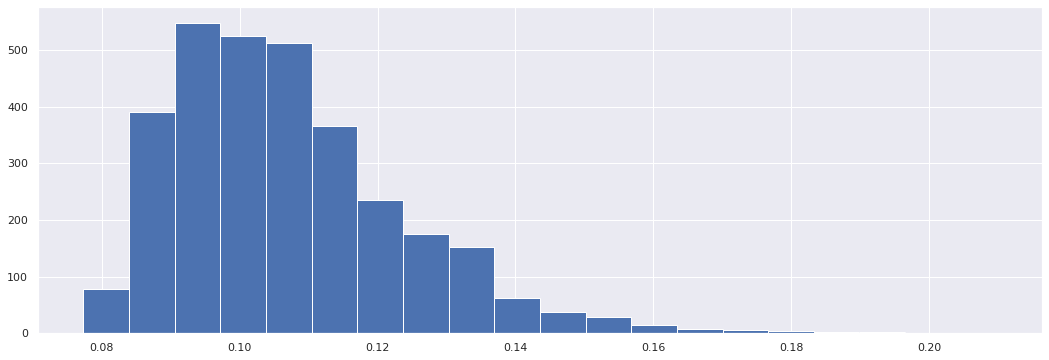

In [102]:
f, ax = plt.subplots(figsize=(18, 6))
accuracy_model_DTC['result_sMAPE'].hist(bins = 20)

Лучшая модель имеет следующие параметры

In [103]:
result_sMAPE_DTC_min = accuracy_model_DTC['result_sMAPE'].min()
accuracy_model_DTC.query('result_sMAPE == @result_sMAPE_DTC_min')

,result_sMAPE,max_depth,min_samples_split,min_samples_leaf,max_features
555,0.077331,6.0,10.0,1.0,6.0


Выполним кросс-валидацию модели

In [104]:
model_dtr = DecisionTreeRegressor(
                    random_state=12345, 
                    max_depth=6,
                    min_samples_split=10,
                    min_samples_leaf=1,
                    max_features=6)
score_dtr = my_cross_val_score(model_dtr, train_features, train_target)
test_scores_train.append(score_lr)
print('Средняя оценка качества модели на обучающей выборке равна {:.4f}'.format(score_dtr))

Средняя оценка качества модели на обучающей выборке равна 0.0773


In [105]:
predictions_test_dtr = pd.DataFrame(model_dtr.predict(test_features), 
                                    columns = ['rougher.output.recovery', 'final.output.recovery'])
score_dtr = result_sMAPE(predictions_test_dtr, test_target)
test_scores_test.append(score_dtr)
print('Итоговая метрика на тестовой выборке равна {:.4f}'.format(score_dtr))

Итоговая метрика на тестовой выборке равна 0.0778


#### Рассмотрим алгоритм случайного леса

У алгоритма Случайный лес есть следующие гиперпараметры:
<li>n_estimators - количество деревьев в лесу;</li>
<li>max_depth — максимальная глубина дерева;</li>
<li>min_samples_split — минимальное число объектов в узле дерева, достаточное для дальнейшего разделения;</li>
<li>min_samples_leaf — минимальное число объектов в листьях дерева нижних узлах с ответами.</li>

Чем больше деревьев, тем дольше модель будет учиться, но результат станет лучше (и наоборот).
Если сделать гиперпараметр n_estimators больше, модель начнёт разрастаться и медленно обучаться. Это плохо. Мало деревьев и
результаты не лучше. Тоже плохо

In [106]:
#Количество деревьев в случайном лесу
n_estimators = [int(x) for x in np.linspace(start = 2, stop = 30, num = 15)]
#Количество полей , которые необходимо учитывать при каждом разделении
max_features = [int(x) for x in np.linspace(2, 40, num = 20)]
# Максимальное количество уровней в дереве
max_depth = [int(x) for x in np.linspace(2, 20, num = 10)]
max_depth.append(None)
# Минимальное количество выборок, необходимых для разделения узла
min_samples_split = [2, 5, 10]
# Минимальное количество образцов, необходимое на каждом листовом узле
min_samples_leaf = [1, 2, 4]
# Способ отбора образцов для обучения каждого дерева
bootstrap = [True, False]

# Создаем случайную сетку
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30], 'max_features': [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40], 'max_depth': [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [107]:
# Функция печатает TOP3 лучших результатов
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})"
                  .format(results['mean_test_score'][candidate],
                          results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [108]:
start = time() #время выполнения 3 минуты
rf = RandomForestRegressor(random_state=12345)
# Случайный поиск параметров с кросс-валдицией, поиск с шагом 100 различных комбинаций параметров
rf_random = RandomizedSearchCV( estimator = rf, param_distributions = random_grid,   n_iter = 100, cv = 3, 
                               verbose=0, random_state=12345, n_jobs = -1, )
rf_random.fit(train_features, train_target)
rf_random.best_params_

print('Время выполнения: {0:0.2f} сек'.format(time() - start))

/opt/conda/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multi

/opt/conda/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multi

/opt/conda/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multi

/opt/conda/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multi

/opt/conda/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multi

/opt/conda/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multi

/opt/conda/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multi

/opt/conda/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multi

/opt/conda/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multi

/opt/conda/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multi

/opt/conda/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multi

/opt/conda/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multi

/opt/conda/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multi

/opt/conda/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multi

/opt/conda/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multi

/opt/conda/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multi

/opt/conda/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multi

/opt/conda/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multi

/opt/conda/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multi

Время выполнения: 1044.86 сек


Распечаем параметры трёх лучших моделей

In [109]:
report(rf_random.cv_results_)

Model with rank: 1
Mean validation score: -0.155 (std: 0.286)
Parameters: {'n_estimators': 8, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 22, 'max_depth': 6, 'bootstrap': True}

Model with rank: 2
Mean validation score: -0.169 (std: 0.317)
Parameters: {'n_estimators': 24, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 12, 'max_depth': 8, 'bootstrap': True}

Model with rank: 3
Mean validation score: -0.181 (std: 0.300)
Parameters: {'n_estimators': 10, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 16, 'max_depth': 14, 'bootstrap': True}



Выберим модель с ранком 1 и далее будем работать с ней

Выполним кросс-валидацию модели

In [110]:
model_rf_1 = RandomForestRegressor(
                    random_state=12345, 
                    max_depth=6, n_estimators = 8, min_samples_split = 2, min_samples_leaf = 2 , max_features = 22, 
                    bootstrap = True)
score_rf = my_cross_val_score(model_rf_1, train_features, train_target)
test_scores_train.append(score_rf)
print('Средняя оценка качества модели на обучающей выборке равна {:.4f}'.format(score_rf))

Средняя оценка качества модели на обучающей выборке равна 0.0813


In [111]:
predictions_test_rf = pd.DataFrame(model_rf_1.predict(test_features), 
                                    columns = ['rougher.output.recovery', 'final.output.recovery'])
score_rf  = result_sMAPE(test_target, predictions_test_rf)
test_scores_test.append(score_rf)
print('Итоговая метрика на тестовой выборке равна {:.4f}'.format(score_rf))

Итоговая метрика на тестовой выборке равна 0.0695


In [112]:
#функция тупого предсказателя
#df1 - данные для которых будет рассчитана медианна и среднее значение
def my_dummy(df , df1, strategy, const):
    predictions_dummy = pd.DataFrame(
                        columns = ['rougher.output.recovery', 'final.output.recovery'], index=range(len(df.index)))
    if strategy == 'median':
        predictions_dummy['rougher.output.recovery'] = df1['rougher.output.recovery'].median()
        predictions_dummy['final.output.recovery'] = df1['final.output.recovery'].median()
    if strategy == 'mean':
        predictions_dummy['rougher.output.recovery'] = df1['rougher.output.recovery'].mean()
        predictions_dummy['final.output.recovery'] = df1['final.output.recovery'].mean() 
    if strategy == 'const':
        predictions_dummy['rougher.output.recovery'] = const
        predictions_dummy['final.output.recovery'] = const           
    df_train_target = df[['rougher.output.recovery','final.output.recovery']]
    return result_sMAPE(df_train_target, predictions_dummy)

In [113]:
def my_test_scores(df, df1, title): #создадим массив с итоговыми значениями метрик для разных стратегий тупого предсказателя
    strategies = ['median', 'mean', 'const']
    test_scores = []
    for s in strategies:
        score = my_dummy(df, df1, s , 50)
        print('Итоговая метрика на {} выборке для {} равна {:.4f}'.format(title, s , score))
        test_scores.append(score)
    
    return test_scores

In [114]:
def print_plot_scores(arr_scores, title):
    strategies = ['LinearRegression','DecisionTree','randomforest','median', 'mean', 'const']
    f, ax = plt.subplots(figsize=(15, 6))
    sns.stripplot(strategies, arr_scores, ax = ax)
    ax.set(xlabel ='Strategy', ylabel ='Test Score')
    plt.title(title)
    plt.show()

In [115]:
test_scores_train = test_scores_train + my_test_scores(df_train, df_train, 'обучающей')
test_scores_test = test_scores_test + my_test_scores(df_test, df_train, 'тестовой')

Итоговая метрика на обучающей выборке для median равна 0.1112
Итоговая метрика на обучающей выборке для mean равна 0.1129
Итоговая метрика на обучающей выборке для const равна 0.3625
Итоговая метрика на тестовой выборке для median равна 0.0948
Итоговая метрика на тестовой выборке для mean равна 0.1029
Итоговая метрика на тестовой выборке для const равна 0.3896


In [116]:
pd.Series(test_scores_train, index = ['LinearRegression','DecisionTree','randomforest','median', 'mean', 'const']).sort_values()

DecisionTree        0.075859
randomforest        0.081341
LinearRegression    0.095157
median              0.111190
mean                0.112926
const               0.362531
dtype: float64

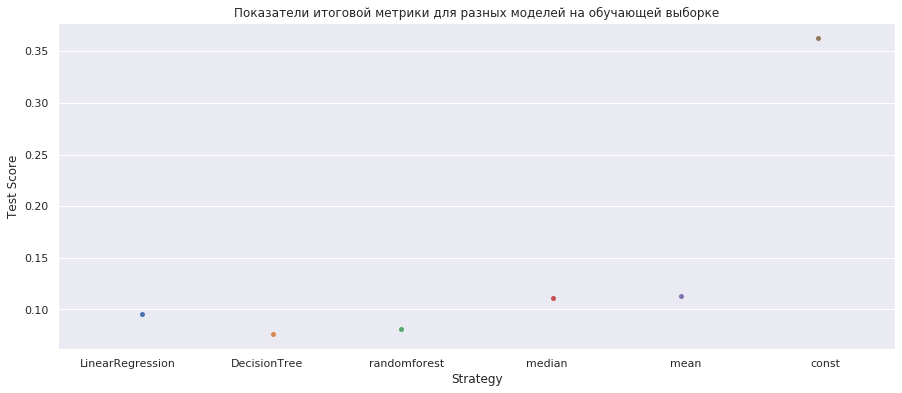

In [117]:
print_plot_scores(test_scores_train, 'Показатели итоговой метрики для разных моделей на обучающей выборке')

In [118]:
pd.Series(test_scores_test, index = ['LinearRegression','DecisionTree','randomforest','median', 'mean', 'const']).sort_values()

randomforest        0.069484
LinearRegression    0.075859
DecisionTree        0.077777
median              0.094799
mean                0.102896
const               0.389617
dtype: float64

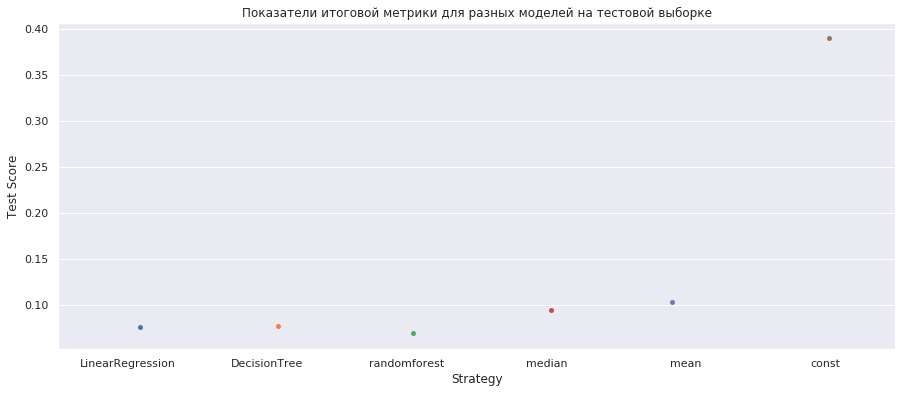

In [119]:
print_plot_scores(test_scores_test, 'Показатели итоговой метрики для разных моделей на тестовой выборке')

### Вывод <a class="anchor" id="third-conclusion"></a>

1. Было рассмотрено три модели: линейная регрессия, модель решающего дерева и модель случайного леса.
2. Также было рассмотрено три модели тупого предсказателя на основе медианного и среднего значений целевых признаков и константы.
3. Модель на основе случайного леса показала наилучшие результаты на тестовой выборке, но заняла второе место на обучающей выборке 
4. Модель на основе решающего дерева показала наилучшие результаты на обучающей выборке, но заняла третье место на тестовой выборке. У модели решающего дерева стабильные результаты. У этой модели самый минимальный интервал между двумя значениями.
5. Модель на основе линейной регрессии на обучающей выборке заняла третье место, но на тестовой выборке заняла второе место, обогнав модель решающего дерева.
6. Модель на основе медианного может быть очень полезной  

_В итоге, лучше взять модель на основе решающего дерева за стабильные результаты._